In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1_native_k5_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 198)
(3944610, 8)
validation
(464344, 198)
(464344, 8)
test
(574820, 198)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 198)]             0         


 dense (Dense)               (None, 1024)              203776    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 893832 (3.41 MB)


Trainable params: 893832 (3.41 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000



  1/395 [..............................] - ETA: 11:07 - loss: 2.3077 - STD: 0.0780 - MAE: 0.2176


  5/395 [..............................] - ETA: 5s - loss: 2.1442 - STD: 0.0528 - MAE: 0.2166   


  9/395 [..............................] - ETA: 5s - loss: 2.1169 - STD: 0.0495 - MAE: 0.2167


 13/395 [..............................] - ETA: 5s - loss: 2.1014 - STD: 0.0471 - MAE: 0.2166


 17/395 [>.............................] - ETA: 5s - loss: 2.0913 - STD: 0.0431 - MAE: 0.2167


 21/395 [>.............................] - ETA: 5s - loss: 2.0855 - STD: 0.0419 - MAE: 0.2167


 25/395 [>.............................] - ETA: 5s - loss: 2.0812 - STD: 0.0408 - MAE: 0.2167


 29/395 [=>............................] - ETA: 5s - loss: 2.0771 - STD: 0.0391 - MAE: 0.2167


 33/395 [=>............................] - ETA: 5s - loss: 2.0743 - STD: 0.0387 - MAE: 0.2167


 37/395 [=>............................] - ETA: 5s - loss: 2.0720 - STD: 0.0383 - MAE: 0.2167


 41/395 [==>...........................] - ETA: 5s - loss: 2.0702 - STD: 0.0373 - MAE: 0.2167


 45/395 [==>...........................] - ETA: 4s - loss: 2.0684 - STD: 0.0368 - MAE: 0.2167


 49/395 [==>...........................] - ETA: 4s - loss: 2.0670 - STD: 0.0367 - MAE: 0.2167


 53/395 [===>..........................] - ETA: 4s - loss: 2.0658 - STD: 0.0361 - MAE: 0.2167


 57/395 [===>..........................] - ETA: 4s - loss: 2.0647 - STD: 0.0359 - MAE: 0.2167


 61/395 [===>..........................] - ETA: 4s - loss: 2.0636 - STD: 0.0357 - MAE: 0.2167


 65/395 [===>..........................] - ETA: 4s - loss: 2.0626 - STD: 0.0355 - MAE: 0.2167


 69/395 [====>.........................] - ETA: 4s - loss: 2.0615 - STD: 0.0353 - MAE: 0.2167


 73/395 [====>.........................] - ETA: 4s - loss: 2.0603 - STD: 0.0351 - MAE: 0.2166


 77/395 [====>.........................] - ETA: 4s - loss: 2.0587 - STD: 0.0351 - MAE: 0.2166


 81/395 [=====>........................] - ETA: 4s - loss: 2.0567 - STD: 0.0351 - MAE: 0.2165


 85/395 [=====>........................] - ETA: 4s - loss: 2.0542 - STD: 0.0353 - MAE: 0.2164


 89/395 [=====>........................] - ETA: 4s - loss: 2.0513 - STD: 0.0357 - MAE: 0.2163


 93/395 [======>.......................] - ETA: 4s - loss: 2.0476 - STD: 0.0363 - MAE: 0.2161


 97/395 [======>.......................] - ETA: 4s - loss: 2.0437 - STD: 0.0372 - MAE: 0.2159


101/395 [======>.......................] - ETA: 4s - loss: 2.0396 - STD: 0.0382 - MAE: 0.2157


105/395 [======>.......................] - ETA: 4s - loss: 2.0354 - STD: 0.0392 - MAE: 0.2155


109/395 [=======>......................] - ETA: 4s - loss: 2.0316 - STD: 0.0402 - MAE: 0.2153


113/395 [=======>......................] - ETA: 3s - loss: 2.0277 - STD: 0.0411 - MAE: 0.2151


117/395 [=======>......................] - ETA: 3s - loss: 2.0236 - STD: 0.0419 - MAE: 0.2149


121/395 [========>.....................] - ETA: 3s - loss: 2.0196 - STD: 0.0428 - MAE: 0.2147


125/395 [========>.....................] - ETA: 3s - loss: 2.0156 - STD: 0.0438 - MAE: 0.2144


129/395 [========>.....................] - ETA: 3s - loss: 2.0117 - STD: 0.0447 - MAE: 0.2142


133/395 [=========>....................] - ETA: 3s - loss: 2.0078 - STD: 0.0457 - MAE: 0.2139


135/395 [=========>....................] - ETA: 5s - loss: 2.0064 - STD: 0.0462 - MAE: 0.2138


139/395 [=========>....................] - ETA: 5s - loss: 2.0026 - STD: 0.0472 - MAE: 0.2136


143/395 [=========>....................] - ETA: 5s - loss: 1.9988 - STD: 0.0481 - MAE: 0.2133


147/395 [==========>...................] - ETA: 5s - loss: 1.9951 - STD: 0.0491 - MAE: 0.2131


151/395 [==========>...................] - ETA: 4s - loss: 1.9915 - STD: 0.0500 - MAE: 0.2128


155/395 [==========>...................] - ETA: 4s - loss: 1.9878 - STD: 0.0509 - MAE: 0.2126


159/395 [===========>..................] - ETA: 4s - loss: 1.9842 - STD: 0.0518 - MAE: 0.2124


163/395 [===========>..................] - ETA: 4s - loss: 1.9804 - STD: 0.0527 - MAE: 0.2121


167/395 [===========>..................] - ETA: 4s - loss: 1.9768 - STD: 0.0536 - MAE: 0.2119


171/395 [===========>..................] - ETA: 4s - loss: 1.9731 - STD: 0.0544 - MAE: 0.2116


175/395 [============>.................] - ETA: 4s - loss: 1.9694 - STD: 0.0553 - MAE: 0.2114


179/395 [============>.................] - ETA: 4s - loss: 1.9658 - STD: 0.0562 - MAE: 0.2111


183/395 [============>.................] - ETA: 4s - loss: 1.9623 - STD: 0.0570 - MAE: 0.2109


187/395 [=============>................] - ETA: 3s - loss: 1.9587 - STD: 0.0578 - MAE: 0.2107


191/395 [=============>................] - ETA: 3s - loss: 1.9552 - STD: 0.0586 - MAE: 0.2104


195/395 [=============>................] - ETA: 3s - loss: 1.9516 - STD: 0.0594 - MAE: 0.2102


199/395 [==============>...............] - ETA: 3s - loss: 1.9483 - STD: 0.0601 - MAE: 0.2100


203/395 [==============>...............] - ETA: 3s - loss: 1.9450 - STD: 0.0609 - MAE: 0.2098


207/395 [==============>...............] - ETA: 3s - loss: 1.9418 - STD: 0.0616 - MAE: 0.2095


211/395 [===============>..............] - ETA: 3s - loss: 1.9387 - STD: 0.0623 - MAE: 0.2093


215/395 [===============>..............] - ETA: 3s - loss: 1.9356 - STD: 0.0629 - MAE: 0.2091


219/395 [===============>..............] - ETA: 3s - loss: 1.9326 - STD: 0.0636 - MAE: 0.2089


223/395 [===============>..............] - ETA: 3s - loss: 1.9296 - STD: 0.0643 - MAE: 0.2087


227/395 [================>.............] - ETA: 3s - loss: 1.9268 - STD: 0.0649 - MAE: 0.2085


231/395 [================>.............] - ETA: 2s - loss: 1.9240 - STD: 0.0655 - MAE: 0.2084


235/395 [================>.............] - ETA: 2s - loss: 1.9212 - STD: 0.0661 - MAE: 0.2082


239/395 [=================>............] - ETA: 2s - loss: 1.9185 - STD: 0.0667 - MAE: 0.2080


243/395 [=================>............] - ETA: 2s - loss: 1.9158 - STD: 0.0673 - MAE: 0.2078


247/395 [=================>............] - ETA: 2s - loss: 1.9133 - STD: 0.0679 - MAE: 0.2076


251/395 [==================>...........] - ETA: 2s - loss: 1.9108 - STD: 0.0685 - MAE: 0.2074


255/395 [==================>...........] - ETA: 2s - loss: 1.9082 - STD: 0.0690 - MAE: 0.2073


259/395 [==================>...........] - ETA: 2s - loss: 1.9059 - STD: 0.0696 - MAE: 0.2071


263/395 [==================>...........] - ETA: 2s - loss: 1.9035 - STD: 0.0701 - MAE: 0.2070


267/395 [===================>..........] - ETA: 2s - loss: 1.9012 - STD: 0.0707 - MAE: 0.2068


271/395 [===================>..........] - ETA: 2s - loss: 1.8989 - STD: 0.0711 - MAE: 0.2066


275/395 [===================>..........] - ETA: 2s - loss: 1.8967 - STD: 0.0716 - MAE: 0.2065


279/395 [====================>.........] - ETA: 2s - loss: 1.8946 - STD: 0.0721 - MAE: 0.2063


283/395 [====================>.........] - ETA: 1s - loss: 1.8924 - STD: 0.0726 - MAE: 0.2062


287/395 [====================>.........] - ETA: 1s - loss: 1.8904 - STD: 0.0730 - MAE: 0.2060


291/395 [=====================>........] - ETA: 1s - loss: 1.8884 - STD: 0.0735 - MAE: 0.2059


295/395 [=====================>........] - ETA: 1s - loss: 1.8863 - STD: 0.0739 - MAE: 0.2058


299/395 [=====================>........] - ETA: 1s - loss: 1.8841 - STD: 0.0743 - MAE: 0.2056


303/395 [======================>.......] - ETA: 1s - loss: 1.8821 - STD: 0.0748 - MAE: 0.2055


307/395 [======================>.......] - ETA: 1s - loss: 1.8801 - STD: 0.0752 - MAE: 0.2053


311/395 [======================>.......] - ETA: 1s - loss: 1.8782 - STD: 0.0756 - MAE: 0.2052


315/395 [======================>.......] - ETA: 1s - loss: 1.8763 - STD: 0.0760 - MAE: 0.2051


319/395 [=======================>......] - ETA: 1s - loss: 1.8745 - STD: 0.0764 - MAE: 0.2050


323/395 [=======================>......] - ETA: 1s - loss: 1.8726 - STD: 0.0768 - MAE: 0.2048


327/395 [=======================>......] - ETA: 1s - loss: 1.8707 - STD: 0.0772 - MAE: 0.2047


331/395 [========================>.....] - ETA: 1s - loss: 1.8689 - STD: 0.0776 - MAE: 0.2046


335/395 [========================>.....] - ETA: 1s - loss: 1.8671 - STD: 0.0780 - MAE: 0.2045


339/395 [========================>.....] - ETA: 0s - loss: 1.8654 - STD: 0.0783 - MAE: 0.2043


343/395 [=========================>....] - ETA: 0s - loss: 1.8635 - STD: 0.0787 - MAE: 0.2042


347/395 [=========================>....] - ETA: 0s - loss: 1.8619 - STD: 0.0791 - MAE: 0.2041


351/395 [=========================>....] - ETA: 0s - loss: 1.8602 - STD: 0.0794 - MAE: 0.2040


355/395 [=========================>....] - ETA: 0s - loss: 1.8587 - STD: 0.0798 - MAE: 0.2039


359/395 [==========================>...] - ETA: 0s - loss: 1.8570 - STD: 0.0801 - MAE: 0.2038


363/395 [==========================>...] - ETA: 0s - loss: 1.8555 - STD: 0.0805 - MAE: 0.2036


367/395 [==========================>...] - ETA: 0s - loss: 1.8539 - STD: 0.0808 - MAE: 0.2035


371/395 [===========================>..] - ETA: 0s - loss: 1.8523 - STD: 0.0811 - MAE: 0.2034


375/395 [===========================>..] - ETA: 0s - loss: 1.8507 - STD: 0.0814 - MAE: 0.2033


379/395 [===========================>..] - ETA: 0s - loss: 1.8490 - STD: 0.0818 - MAE: 0.2032


383/395 [============================>.] - ETA: 0s - loss: 1.8475 - STD: 0.0821 - MAE: 0.2031


387/395 [============================>.] - ETA: 0s - loss: 1.8459 - STD: 0.0824 - MAE: 0.2030


391/395 [============================>.] - ETA: 0s - loss: 1.8444 - STD: 0.0827 - MAE: 0.2029


395/395 [==============================] - ETA: 0s - loss: 1.8430 - STD: 0.0830 - MAE: 0.2028


395/395 [==============================] - 9s 19ms/step - loss: 1.8430 - STD: 0.0830 - MAE: 0.2028 - val_loss: 1.6885 - val_STD: 0.1024 - val_MAE: 0.1935


Epoch 2/10000



  1/395 [..............................] - ETA: 14s - loss: 1.6977 - STD: 0.1085 - MAE: 0.1938


  5/395 [..............................] - ETA: 5s - loss: 1.6899 - STD: 0.1137 - MAE: 0.1923 


  9/395 [..............................] - ETA: 5s - loss: 1.6914 - STD: 0.1137 - MAE: 0.1923


 13/395 [..............................] - ETA: 5s - loss: 1.6914 - STD: 0.1139 - MAE: 0.1923


 17/395 [>.............................] - ETA: 5s - loss: 1.6934 - STD: 0.1139 - MAE: 0.1924


 21/395 [>.............................] - ETA: 5s - loss: 1.6923 - STD: 0.1141 - MAE: 0.1923


 25/395 [>.............................] - ETA: 5s - loss: 1.6901 - STD: 0.1144 - MAE: 0.1921


 29/395 [=>............................] - ETA: 5s - loss: 1.6888 - STD: 0.1144 - MAE: 0.1921


 33/395 [=>............................] - ETA: 5s - loss: 1.6876 - STD: 0.1146 - MAE: 0.1920


 37/395 [=>............................] - ETA: 5s - loss: 1.6858 - STD: 0.1148 - MAE: 0.1919


 41/395 [==>...........................] - ETA: 5s - loss: 1.6848 - STD: 0.1148 - MAE: 0.1918


 45/395 [==>...........................] - ETA: 4s - loss: 1.6842 - STD: 0.1150 - MAE: 0.1918


 49/395 [==>...........................] - ETA: 4s - loss: 1.6840 - STD: 0.1150 - MAE: 0.1918


 53/395 [===>..........................] - ETA: 4s - loss: 1.6829 - STD: 0.1152 - MAE: 0.1917


 57/395 [===>..........................] - ETA: 4s - loss: 1.6821 - STD: 0.1154 - MAE: 0.1916


 61/395 [===>..........................] - ETA: 4s - loss: 1.6809 - STD: 0.1154 - MAE: 0.1916


 65/395 [===>..........................] - ETA: 4s - loss: 1.6801 - STD: 0.1156 - MAE: 0.1915


 69/395 [====>.........................] - ETA: 4s - loss: 1.6790 - STD: 0.1157 - MAE: 0.1914


 73/395 [====>.........................] - ETA: 4s - loss: 1.6779 - STD: 0.1159 - MAE: 0.1913


 77/395 [====>.........................] - ETA: 4s - loss: 1.6768 - STD: 0.1161 - MAE: 0.1913


 81/395 [=====>........................] - ETA: 4s - loss: 1.6767 - STD: 0.1162 - MAE: 0.1912


 85/395 [=====>........................] - ETA: 4s - loss: 1.6761 - STD: 0.1163 - MAE: 0.1912


 89/395 [=====>........................] - ETA: 4s - loss: 1.6756 - STD: 0.1163 - MAE: 0.1911


 93/395 [======>.......................] - ETA: 4s - loss: 1.6751 - STD: 0.1166 - MAE: 0.1911


 97/395 [======>.......................] - ETA: 4s - loss: 1.6746 - STD: 0.1166 - MAE: 0.1910


101/395 [======>.......................] - ETA: 4s - loss: 1.6740 - STD: 0.1168 - MAE: 0.1910


105/395 [======>.......................] - ETA: 4s - loss: 1.6731 - STD: 0.1168 - MAE: 0.1909


109/395 [=======>......................] - ETA: 4s - loss: 1.6724 - STD: 0.1169 - MAE: 0.1909


113/395 [=======>......................] - ETA: 4s - loss: 1.6715 - STD: 0.1170 - MAE: 0.1908


117/395 [=======>......................] - ETA: 3s - loss: 1.6707 - STD: 0.1171 - MAE: 0.1908


121/395 [========>.....................] - ETA: 3s - loss: 1.6700 - STD: 0.1172 - MAE: 0.1907


125/395 [========>.....................] - ETA: 3s - loss: 1.6697 - STD: 0.1173 - MAE: 0.1907


129/395 [========>.....................] - ETA: 3s - loss: 1.6690 - STD: 0.1174 - MAE: 0.1906


133/395 [=========>....................] - ETA: 3s - loss: 1.6683 - STD: 0.1175 - MAE: 0.1906


137/395 [=========>....................] - ETA: 3s - loss: 1.6678 - STD: 0.1176 - MAE: 0.1905


141/395 [=========>....................] - ETA: 3s - loss: 1.6671 - STD: 0.1177 - MAE: 0.1905


145/395 [==========>...................] - ETA: 3s - loss: 1.6665 - STD: 0.1179 - MAE: 0.1904


149/395 [==========>...................] - ETA: 3s - loss: 1.6659 - STD: 0.1179 - MAE: 0.1904


153/395 [==========>...................] - ETA: 3s - loss: 1.6653 - STD: 0.1180 - MAE: 0.1903


157/395 [==========>...................] - ETA: 3s - loss: 1.6648 - STD: 0.1181 - MAE: 0.1903


161/395 [===========>..................] - ETA: 3s - loss: 1.6642 - STD: 0.1182 - MAE: 0.1903


165/395 [===========>..................] - ETA: 3s - loss: 1.6635 - STD: 0.1183 - MAE: 0.1902


169/395 [===========>..................] - ETA: 3s - loss: 1.6629 - STD: 0.1184 - MAE: 0.1902


174/395 [============>.................] - ETA: 3s - loss: 1.6624 - STD: 0.1185 - MAE: 0.1901


178/395 [============>.................] - ETA: 3s - loss: 1.6619 - STD: 0.1186 - MAE: 0.1901


182/395 [============>.................] - ETA: 3s - loss: 1.6613 - STD: 0.1186 - MAE: 0.1900


186/395 [=============>................] - ETA: 2s - loss: 1.6609 - STD: 0.1187 - MAE: 0.1900


190/395 [=============>................] - ETA: 2s - loss: 1.6605 - STD: 0.1188 - MAE: 0.1900


194/395 [=============>................] - ETA: 2s - loss: 1.6599 - STD: 0.1189 - MAE: 0.1899


198/395 [==============>...............] - ETA: 2s - loss: 1.6594 - STD: 0.1190 - MAE: 0.1899


202/395 [==============>...............] - ETA: 2s - loss: 1.6588 - STD: 0.1191 - MAE: 0.1898


206/395 [==============>...............] - ETA: 2s - loss: 1.6584 - STD: 0.1192 - MAE: 0.1898


210/395 [==============>...............] - ETA: 2s - loss: 1.6581 - STD: 0.1193 - MAE: 0.1897


214/395 [===============>..............] - ETA: 2s - loss: 1.6578 - STD: 0.1193 - MAE: 0.1897


218/395 [===============>..............] - ETA: 2s - loss: 1.6576 - STD: 0.1194 - MAE: 0.1897


222/395 [===============>..............] - ETA: 2s - loss: 1.6573 - STD: 0.1195 - MAE: 0.1897


226/395 [================>.............] - ETA: 2s - loss: 1.6568 - STD: 0.1195 - MAE: 0.1896


230/395 [================>.............] - ETA: 2s - loss: 1.6564 - STD: 0.1196 - MAE: 0.1896


234/395 [================>.............] - ETA: 2s - loss: 1.6559 - STD: 0.1197 - MAE: 0.1896


238/395 [=================>............] - ETA: 2s - loss: 1.6553 - STD: 0.1197 - MAE: 0.1895


242/395 [=================>............] - ETA: 2s - loss: 1.6548 - STD: 0.1198 - MAE: 0.1895


246/395 [=================>............] - ETA: 2s - loss: 1.6542 - STD: 0.1199 - MAE: 0.1894


250/395 [=================>............] - ETA: 2s - loss: 1.6536 - STD: 0.1200 - MAE: 0.1894


254/395 [==================>...........] - ETA: 2s - loss: 1.6530 - STD: 0.1200 - MAE: 0.1893


258/395 [==================>...........] - ETA: 1s - loss: 1.6524 - STD: 0.1201 - MAE: 0.1893


262/395 [==================>...........] - ETA: 1s - loss: 1.6519 - STD: 0.1202 - MAE: 0.1893


266/395 [===================>..........] - ETA: 1s - loss: 1.6513 - STD: 0.1203 - MAE: 0.1892


270/395 [===================>..........] - ETA: 1s - loss: 1.6509 - STD: 0.1204 - MAE: 0.1892


274/395 [===================>..........] - ETA: 1s - loss: 1.6503 - STD: 0.1204 - MAE: 0.1891


278/395 [====================>.........] - ETA: 1s - loss: 1.6497 - STD: 0.1205 - MAE: 0.1891


282/395 [====================>.........] - ETA: 1s - loss: 1.6492 - STD: 0.1206 - MAE: 0.1890


286/395 [====================>.........] - ETA: 1s - loss: 1.6488 - STD: 0.1207 - MAE: 0.1890


290/395 [=====================>........] - ETA: 1s - loss: 1.6484 - STD: 0.1208 - MAE: 0.1890


294/395 [=====================>........] - ETA: 1s - loss: 1.6480 - STD: 0.1208 - MAE: 0.1889


298/395 [=====================>........] - ETA: 1s - loss: 1.6474 - STD: 0.1209 - MAE: 0.1889


302/395 [=====================>........] - ETA: 1s - loss: 1.6469 - STD: 0.1210 - MAE: 0.1889


306/395 [======================>.......] - ETA: 1s - loss: 1.6464 - STD: 0.1211 - MAE: 0.1888


310/395 [======================>.......] - ETA: 1s - loss: 1.6460 - STD: 0.1211 - MAE: 0.1888


314/395 [======================>.......] - ETA: 1s - loss: 1.6455 - STD: 0.1212 - MAE: 0.1888


318/395 [=======================>......] - ETA: 1s - loss: 1.6450 - STD: 0.1213 - MAE: 0.1887


322/395 [=======================>......] - ETA: 1s - loss: 1.6445 - STD: 0.1214 - MAE: 0.1887


326/395 [=======================>......] - ETA: 0s - loss: 1.6440 - STD: 0.1214 - MAE: 0.1886


330/395 [========================>.....] - ETA: 0s - loss: 1.6435 - STD: 0.1215 - MAE: 0.1886


334/395 [========================>.....] - ETA: 0s - loss: 1.6431 - STD: 0.1216 - MAE: 0.1886


338/395 [========================>.....] - ETA: 0s - loss: 1.6427 - STD: 0.1216 - MAE: 0.1885


342/395 [========================>.....] - ETA: 0s - loss: 1.6423 - STD: 0.1217 - MAE: 0.1885


346/395 [=========================>....] - ETA: 0s - loss: 1.6421 - STD: 0.1218 - MAE: 0.1885


350/395 [=========================>....] - ETA: 0s - loss: 1.6418 - STD: 0.1219 - MAE: 0.1884


354/395 [=========================>....] - ETA: 0s - loss: 1.6414 - STD: 0.1219 - MAE: 0.1884


358/395 [==========================>...] - ETA: 0s - loss: 1.6411 - STD: 0.1220 - MAE: 0.1884


362/395 [==========================>...] - ETA: 0s - loss: 1.6407 - STD: 0.1220 - MAE: 0.1883


366/395 [==========================>...] - ETA: 0s - loss: 1.6402 - STD: 0.1221 - MAE: 0.1883


370/395 [===========================>..] - ETA: 0s - loss: 1.6397 - STD: 0.1222 - MAE: 0.1883


374/395 [===========================>..] - ETA: 0s - loss: 1.6393 - STD: 0.1222 - MAE: 0.1882


378/395 [===========================>..] - ETA: 0s - loss: 1.6388 - STD: 0.1223 - MAE: 0.1882


382/395 [============================>.] - ETA: 0s - loss: 1.6383 - STD: 0.1224 - MAE: 0.1882


386/395 [============================>.] - ETA: 0s - loss: 1.6379 - STD: 0.1224 - MAE: 0.1881


390/395 [============================>.] - ETA: 0s - loss: 1.6375 - STD: 0.1225 - MAE: 0.1881


394/395 [============================>.] - ETA: 0s - loss: 1.6370 - STD: 0.1225 - MAE: 0.1881


395/395 [==============================] - 6s 15ms/step - loss: 1.6369 - STD: 0.1226 - MAE: 0.1881 - val_loss: 1.6086 - val_STD: 0.1206 - val_MAE: 0.1860


Epoch 3/10000



  1/395 [..............................] - ETA: 14s - loss: 1.5881 - STD: 0.1298 - MAE: 0.1844


  5/395 [..............................] - ETA: 5s - loss: 1.5971 - STD: 0.1308 - MAE: 0.1844 


  9/395 [..............................] - ETA: 5s - loss: 1.5967 - STD: 0.1298 - MAE: 0.1847


 13/395 [..............................] - ETA: 5s - loss: 1.5965 - STD: 0.1296 - MAE: 0.1847


 17/395 [>.............................] - ETA: 5s - loss: 1.5955 - STD: 0.1294 - MAE: 0.1847


 21/395 [>.............................] - ETA: 5s - loss: 1.5942 - STD: 0.1295 - MAE: 0.1846


 25/395 [>.............................] - ETA: 5s - loss: 1.5942 - STD: 0.1296 - MAE: 0.1846


 29/395 [=>............................] - ETA: 5s - loss: 1.5936 - STD: 0.1297 - MAE: 0.1845


 33/395 [=>............................] - ETA: 5s - loss: 1.5938 - STD: 0.1295 - MAE: 0.1846


 37/395 [=>............................] - ETA: 5s - loss: 1.5938 - STD: 0.1296 - MAE: 0.1845


 41/395 [==>...........................] - ETA: 5s - loss: 1.5952 - STD: 0.1297 - MAE: 0.1846


 45/395 [==>...........................] - ETA: 5s - loss: 1.5960 - STD: 0.1295 - MAE: 0.1846


 49/395 [==>...........................] - ETA: 4s - loss: 1.5960 - STD: 0.1295 - MAE: 0.1846


 53/395 [===>..........................] - ETA: 4s - loss: 1.5959 - STD: 0.1295 - MAE: 0.1846


 57/395 [===>..........................] - ETA: 4s - loss: 1.5962 - STD: 0.1295 - MAE: 0.1846


 61/395 [===>..........................] - ETA: 4s - loss: 1.5959 - STD: 0.1295 - MAE: 0.1846


 65/395 [===>..........................] - ETA: 4s - loss: 1.5956 - STD: 0.1296 - MAE: 0.1846


 69/395 [====>.........................] - ETA: 4s - loss: 1.5954 - STD: 0.1296 - MAE: 0.1846


 73/395 [====>.........................] - ETA: 4s - loss: 1.5949 - STD: 0.1297 - MAE: 0.1846


 77/395 [====>.........................] - ETA: 4s - loss: 1.5944 - STD: 0.1297 - MAE: 0.1845


 81/395 [=====>........................] - ETA: 4s - loss: 1.5937 - STD: 0.1297 - MAE: 0.1845


 85/395 [=====>........................] - ETA: 4s - loss: 1.5931 - STD: 0.1298 - MAE: 0.1845


 89/395 [=====>........................] - ETA: 4s - loss: 1.5923 - STD: 0.1298 - MAE: 0.1844


 93/395 [======>.......................] - ETA: 4s - loss: 1.5918 - STD: 0.1299 - MAE: 0.1844


 97/395 [======>.......................] - ETA: 4s - loss: 1.5912 - STD: 0.1300 - MAE: 0.1843


101/395 [======>.......................] - ETA: 4s - loss: 1.5910 - STD: 0.1300 - MAE: 0.1843


105/395 [======>.......................] - ETA: 4s - loss: 1.5905 - STD: 0.1301 - MAE: 0.1843


109/395 [=======>......................] - ETA: 4s - loss: 1.5902 - STD: 0.1301 - MAE: 0.1842


113/395 [=======>......................] - ETA: 3s - loss: 1.5900 - STD: 0.1301 - MAE: 0.1842


117/395 [=======>......................] - ETA: 3s - loss: 1.5894 - STD: 0.1302 - MAE: 0.1842


121/395 [========>.....................] - ETA: 3s - loss: 1.5890 - STD: 0.1303 - MAE: 0.1842


125/395 [========>.....................] - ETA: 3s - loss: 1.5886 - STD: 0.1303 - MAE: 0.1841


129/395 [========>.....................] - ETA: 3s - loss: 1.5882 - STD: 0.1304 - MAE: 0.1841


133/395 [=========>....................] - ETA: 3s - loss: 1.5879 - STD: 0.1304 - MAE: 0.1841


137/395 [=========>....................] - ETA: 3s - loss: 1.5875 - STD: 0.1304 - MAE: 0.1840


141/395 [=========>....................] - ETA: 3s - loss: 1.5876 - STD: 0.1305 - MAE: 0.1840


145/395 [==========>...................] - ETA: 3s - loss: 1.5872 - STD: 0.1305 - MAE: 0.1840


149/395 [==========>...................] - ETA: 3s - loss: 1.5868 - STD: 0.1306 - MAE: 0.1840


153/395 [==========>...................] - ETA: 3s - loss: 1.5865 - STD: 0.1306 - MAE: 0.1840


157/395 [==========>...................] - ETA: 3s - loss: 1.5862 - STD: 0.1306 - MAE: 0.1839


161/395 [===========>..................] - ETA: 3s - loss: 1.5859 - STD: 0.1307 - MAE: 0.1839


165/395 [===========>..................] - ETA: 3s - loss: 1.5857 - STD: 0.1307 - MAE: 0.1839


169/395 [===========>..................] - ETA: 3s - loss: 1.5853 - STD: 0.1308 - MAE: 0.1839


173/395 [============>.................] - ETA: 3s - loss: 1.5850 - STD: 0.1308 - MAE: 0.1838


177/395 [============>.................] - ETA: 3s - loss: 1.5848 - STD: 0.1309 - MAE: 0.1838


181/395 [============>.................] - ETA: 3s - loss: 1.5844 - STD: 0.1309 - MAE: 0.1838


185/395 [=============>................] - ETA: 2s - loss: 1.5842 - STD: 0.1310 - MAE: 0.1838


189/395 [=============>................] - ETA: 2s - loss: 1.5840 - STD: 0.1310 - MAE: 0.1837


193/395 [=============>................] - ETA: 2s - loss: 1.5838 - STD: 0.1310 - MAE: 0.1837


197/395 [=============>................] - ETA: 2s - loss: 1.5836 - STD: 0.1311 - MAE: 0.1837


201/395 [==============>...............] - ETA: 2s - loss: 1.5833 - STD: 0.1311 - MAE: 0.1837


205/395 [==============>...............] - ETA: 2s - loss: 1.5830 - STD: 0.1311 - MAE: 0.1837


209/395 [==============>...............] - ETA: 2s - loss: 1.5828 - STD: 0.1312 - MAE: 0.1837


213/395 [===============>..............] - ETA: 2s - loss: 1.5825 - STD: 0.1312 - MAE: 0.1836


217/395 [===============>..............] - ETA: 2s - loss: 1.5822 - STD: 0.1312 - MAE: 0.1836


221/395 [===============>..............] - ETA: 2s - loss: 1.5820 - STD: 0.1313 - MAE: 0.1836


225/395 [================>.............] - ETA: 2s - loss: 1.5818 - STD: 0.1313 - MAE: 0.1836


229/395 [================>.............] - ETA: 2s - loss: 1.5815 - STD: 0.1314 - MAE: 0.1835


233/395 [================>.............] - ETA: 2s - loss: 1.5812 - STD: 0.1314 - MAE: 0.1835


237/395 [=================>............] - ETA: 2s - loss: 1.5808 - STD: 0.1315 - MAE: 0.1835


241/395 [=================>............] - ETA: 2s - loss: 1.5807 - STD: 0.1315 - MAE: 0.1835


245/395 [=================>............] - ETA: 2s - loss: 1.5804 - STD: 0.1315 - MAE: 0.1835


249/395 [=================>............] - ETA: 2s - loss: 1.5802 - STD: 0.1316 - MAE: 0.1834


253/395 [==================>...........] - ETA: 1s - loss: 1.5801 - STD: 0.1316 - MAE: 0.1834


257/395 [==================>...........] - ETA: 1s - loss: 1.5800 - STD: 0.1316 - MAE: 0.1834


261/395 [==================>...........] - ETA: 1s - loss: 1.5799 - STD: 0.1317 - MAE: 0.1834


265/395 [===================>..........] - ETA: 1s - loss: 1.5800 - STD: 0.1317 - MAE: 0.1834


269/395 [===================>..........] - ETA: 1s - loss: 1.5799 - STD: 0.1317 - MAE: 0.1834


273/395 [===================>..........] - ETA: 1s - loss: 1.5796 - STD: 0.1317 - MAE: 0.1834


277/395 [====================>.........] - ETA: 1s - loss: 1.5795 - STD: 0.1317 - MAE: 0.1834


281/395 [====================>.........] - ETA: 1s - loss: 1.5793 - STD: 0.1318 - MAE: 0.1833


285/395 [====================>.........] - ETA: 1s - loss: 1.5789 - STD: 0.1318 - MAE: 0.1833


289/395 [====================>.........] - ETA: 1s - loss: 1.5787 - STD: 0.1318 - MAE: 0.1833


293/395 [=====================>........] - ETA: 1s - loss: 1.5784 - STD: 0.1318 - MAE: 0.1833


297/395 [=====================>........] - ETA: 1s - loss: 1.5780 - STD: 0.1319 - MAE: 0.1833


301/395 [=====================>........] - ETA: 1s - loss: 1.5778 - STD: 0.1319 - MAE: 0.1832


305/395 [======================>.......] - ETA: 1s - loss: 1.5775 - STD: 0.1320 - MAE: 0.1832


309/395 [======================>.......] - ETA: 1s - loss: 1.5771 - STD: 0.1320 - MAE: 0.1832


313/395 [======================>.......] - ETA: 1s - loss: 1.5769 - STD: 0.1320 - MAE: 0.1832


317/395 [=======================>......] - ETA: 1s - loss: 1.5766 - STD: 0.1321 - MAE: 0.1831


321/395 [=======================>......] - ETA: 1s - loss: 1.5764 - STD: 0.1321 - MAE: 0.1831


325/395 [=======================>......] - ETA: 0s - loss: 1.5762 - STD: 0.1322 - MAE: 0.1831


329/395 [=======================>......] - ETA: 0s - loss: 1.5760 - STD: 0.1322 - MAE: 0.1831


333/395 [========================>.....] - ETA: 0s - loss: 1.5758 - STD: 0.1322 - MAE: 0.1831


337/395 [========================>.....] - ETA: 0s - loss: 1.5755 - STD: 0.1322 - MAE: 0.1831


341/395 [========================>.....] - ETA: 0s - loss: 1.5752 - STD: 0.1323 - MAE: 0.1830


345/395 [=========================>....] - ETA: 0s - loss: 1.5751 - STD: 0.1323 - MAE: 0.1830


349/395 [=========================>....] - ETA: 0s - loss: 1.5749 - STD: 0.1324 - MAE: 0.1830


353/395 [=========================>....] - ETA: 0s - loss: 1.5747 - STD: 0.1324 - MAE: 0.1830


357/395 [==========================>...] - ETA: 0s - loss: 1.5744 - STD: 0.1324 - MAE: 0.1830


361/395 [==========================>...] - ETA: 0s - loss: 1.5742 - STD: 0.1325 - MAE: 0.1830


365/395 [==========================>...] - ETA: 0s - loss: 1.5739 - STD: 0.1325 - MAE: 0.1829


369/395 [===========================>..] - ETA: 0s - loss: 1.5736 - STD: 0.1325 - MAE: 0.1829


373/395 [===========================>..] - ETA: 0s - loss: 1.5733 - STD: 0.1326 - MAE: 0.1829


377/395 [===========================>..] - ETA: 0s - loss: 1.5731 - STD: 0.1326 - MAE: 0.1829


381/395 [===========================>..] - ETA: 0s - loss: 1.5728 - STD: 0.1326 - MAE: 0.1828


385/395 [============================>.] - ETA: 0s - loss: 1.5725 - STD: 0.1327 - MAE: 0.1828


389/395 [============================>.] - ETA: 0s - loss: 1.5724 - STD: 0.1327 - MAE: 0.1828


393/395 [============================>.] - ETA: 0s - loss: 1.5721 - STD: 0.1327 - MAE: 0.1828


395/395 [==============================] - 6s 15ms/step - loss: 1.5720 - STD: 0.1328 - MAE: 0.1828 - val_loss: 1.6088 - val_STD: 0.1259 - val_MAE: 0.1849


Epoch 4/10000



  1/395 [..............................] - ETA: 13s - loss: 1.5444 - STD: 0.1354 - MAE: 0.1811


  5/395 [..............................] - ETA: 5s - loss: 1.5476 - STD: 0.1367 - MAE: 0.1807 


  9/395 [..............................] - ETA: 5s - loss: 1.5457 - STD: 0.1365 - MAE: 0.1807


 13/395 [..............................] - ETA: 5s - loss: 1.5465 - STD: 0.1363 - MAE: 0.1808


 17/395 [>.............................] - ETA: 5s - loss: 1.5473 - STD: 0.1364 - MAE: 0.1808


 21/395 [>.............................] - ETA: 5s - loss: 1.5477 - STD: 0.1364 - MAE: 0.1808


 25/395 [>.............................] - ETA: 5s - loss: 1.5467 - STD: 0.1362 - MAE: 0.1808


 29/395 [=>............................] - ETA: 5s - loss: 1.5475 - STD: 0.1362 - MAE: 0.1809


 33/395 [=>............................] - ETA: 5s - loss: 1.5480 - STD: 0.1364 - MAE: 0.1808


 37/395 [=>............................] - ETA: 5s - loss: 1.5490 - STD: 0.1364 - MAE: 0.1809


 41/395 [==>...........................] - ETA: 5s - loss: 1.5496 - STD: 0.1363 - MAE: 0.1810


 45/395 [==>...........................] - ETA: 4s - loss: 1.5498 - STD: 0.1361 - MAE: 0.1810


 49/395 [==>...........................] - ETA: 4s - loss: 1.5486 - STD: 0.1363 - MAE: 0.1809


 53/395 [===>..........................] - ETA: 4s - loss: 1.5485 - STD: 0.1364 - MAE: 0.1809


 57/395 [===>..........................] - ETA: 4s - loss: 1.5484 - STD: 0.1364 - MAE: 0.1809


 61/395 [===>..........................] - ETA: 4s - loss: 1.5487 - STD: 0.1364 - MAE: 0.1809


 65/395 [===>..........................] - ETA: 4s - loss: 1.5492 - STD: 0.1364 - MAE: 0.1809


 69/395 [====>.........................] - ETA: 4s - loss: 1.5493 - STD: 0.1364 - MAE: 0.1809


 73/395 [====>.........................] - ETA: 4s - loss: 1.5500 - STD: 0.1365 - MAE: 0.1809


 77/395 [====>.........................] - ETA: 4s - loss: 1.5511 - STD: 0.1365 - MAE: 0.1809


 81/395 [=====>........................] - ETA: 4s - loss: 1.5513 - STD: 0.1364 - MAE: 0.1810


 85/395 [=====>........................] - ETA: 4s - loss: 1.5512 - STD: 0.1365 - MAE: 0.1809


 89/395 [=====>........................] - ETA: 4s - loss: 1.5512 - STD: 0.1364 - MAE: 0.1810


 93/395 [======>.......................] - ETA: 4s - loss: 1.5507 - STD: 0.1364 - MAE: 0.1809


 97/395 [======>.......................] - ETA: 4s - loss: 1.5505 - STD: 0.1365 - MAE: 0.1809


101/395 [======>.......................] - ETA: 4s - loss: 1.5505 - STD: 0.1365 - MAE: 0.1809


105/395 [======>.......................] - ETA: 4s - loss: 1.5501 - STD: 0.1364 - MAE: 0.1809


109/395 [=======>......................] - ETA: 4s - loss: 1.5497 - STD: 0.1364 - MAE: 0.1809


113/395 [=======>......................] - ETA: 4s - loss: 1.5494 - STD: 0.1365 - MAE: 0.1809


117/395 [=======>......................] - ETA: 3s - loss: 1.5490 - STD: 0.1366 - MAE: 0.1808


121/395 [========>.....................] - ETA: 3s - loss: 1.5486 - STD: 0.1366 - MAE: 0.1808


125/395 [========>.....................] - ETA: 3s - loss: 1.5482 - STD: 0.1367 - MAE: 0.1808


129/395 [========>.....................] - ETA: 3s - loss: 1.5477 - STD: 0.1367 - MAE: 0.1807


133/395 [=========>....................] - ETA: 3s - loss: 1.5473 - STD: 0.1367 - MAE: 0.1807


137/395 [=========>....................] - ETA: 3s - loss: 1.5472 - STD: 0.1368 - MAE: 0.1807


141/395 [=========>....................] - ETA: 3s - loss: 1.5472 - STD: 0.1367 - MAE: 0.1807


145/395 [==========>...................] - ETA: 3s - loss: 1.5469 - STD: 0.1368 - MAE: 0.1807


149/395 [==========>...................] - ETA: 3s - loss: 1.5467 - STD: 0.1368 - MAE: 0.1807


153/395 [==========>...................] - ETA: 3s - loss: 1.5466 - STD: 0.1368 - MAE: 0.1807


157/395 [==========>...................] - ETA: 3s - loss: 1.5465 - STD: 0.1368 - MAE: 0.1806


161/395 [===========>..................] - ETA: 3s - loss: 1.5462 - STD: 0.1369 - MAE: 0.1806


165/395 [===========>..................] - ETA: 3s - loss: 1.5459 - STD: 0.1369 - MAE: 0.1806


169/395 [===========>..................] - ETA: 3s - loss: 1.5457 - STD: 0.1369 - MAE: 0.1806


173/395 [============>.................] - ETA: 3s - loss: 1.5453 - STD: 0.1370 - MAE: 0.1806


177/395 [============>.................] - ETA: 3s - loss: 1.5450 - STD: 0.1370 - MAE: 0.1805


181/395 [============>.................] - ETA: 3s - loss: 1.5449 - STD: 0.1371 - MAE: 0.1805


185/395 [=============>................] - ETA: 2s - loss: 1.5447 - STD: 0.1371 - MAE: 0.1805


189/395 [=============>................] - ETA: 2s - loss: 1.5445 - STD: 0.1371 - MAE: 0.1805


193/395 [=============>................] - ETA: 2s - loss: 1.5442 - STD: 0.1371 - MAE: 0.1805


197/395 [=============>................] - ETA: 2s - loss: 1.5439 - STD: 0.1372 - MAE: 0.1804


201/395 [==============>...............] - ETA: 2s - loss: 1.5437 - STD: 0.1372 - MAE: 0.1804


205/395 [==============>...............] - ETA: 2s - loss: 1.5436 - STD: 0.1372 - MAE: 0.1804


209/395 [==============>...............] - ETA: 2s - loss: 1.5433 - STD: 0.1373 - MAE: 0.1804


213/395 [===============>..............] - ETA: 2s - loss: 1.5432 - STD: 0.1373 - MAE: 0.1804


217/395 [===============>..............] - ETA: 2s - loss: 1.5430 - STD: 0.1373 - MAE: 0.1804


221/395 [===============>..............] - ETA: 2s - loss: 1.5428 - STD: 0.1374 - MAE: 0.1803


225/395 [================>.............] - ETA: 2s - loss: 1.5429 - STD: 0.1374 - MAE: 0.1803


229/395 [================>.............] - ETA: 2s - loss: 1.5427 - STD: 0.1374 - MAE: 0.1803


233/395 [================>.............] - ETA: 2s - loss: 1.5426 - STD: 0.1374 - MAE: 0.1803


237/395 [=================>............] - ETA: 2s - loss: 1.5424 - STD: 0.1374 - MAE: 0.1803


241/395 [=================>............] - ETA: 2s - loss: 1.5423 - STD: 0.1374 - MAE: 0.1803


245/395 [=================>............] - ETA: 2s - loss: 1.5421 - STD: 0.1375 - MAE: 0.1803


249/395 [=================>............] - ETA: 2s - loss: 1.5420 - STD: 0.1375 - MAE: 0.1803


253/395 [==================>...........] - ETA: 2s - loss: 1.5419 - STD: 0.1375 - MAE: 0.1803


257/395 [==================>...........] - ETA: 1s - loss: 1.5418 - STD: 0.1375 - MAE: 0.1803


261/395 [==================>...........] - ETA: 1s - loss: 1.5417 - STD: 0.1375 - MAE: 0.1802


265/395 [===================>..........] - ETA: 1s - loss: 1.5416 - STD: 0.1375 - MAE: 0.1802


269/395 [===================>..........] - ETA: 1s - loss: 1.5415 - STD: 0.1375 - MAE: 0.1802


273/395 [===================>..........] - ETA: 1s - loss: 1.5414 - STD: 0.1376 - MAE: 0.1802


277/395 [====================>.........] - ETA: 1s - loss: 1.5412 - STD: 0.1376 - MAE: 0.1802


281/395 [====================>.........] - ETA: 1s - loss: 1.5412 - STD: 0.1376 - MAE: 0.1802


285/395 [====================>.........] - ETA: 1s - loss: 1.5410 - STD: 0.1377 - MAE: 0.1802


289/395 [====================>.........] - ETA: 1s - loss: 1.5408 - STD: 0.1377 - MAE: 0.1802


293/395 [=====================>........] - ETA: 1s - loss: 1.5406 - STD: 0.1377 - MAE: 0.1802


297/395 [=====================>........] - ETA: 1s - loss: 1.5404 - STD: 0.1377 - MAE: 0.1802


301/395 [=====================>........] - ETA: 1s - loss: 1.5402 - STD: 0.1377 - MAE: 0.1801


306/395 [======================>.......] - ETA: 1s - loss: 1.5400 - STD: 0.1378 - MAE: 0.1801


310/395 [======================>.......] - ETA: 1s - loss: 1.5399 - STD: 0.1378 - MAE: 0.1801


314/395 [======================>.......] - ETA: 1s - loss: 1.5397 - STD: 0.1378 - MAE: 0.1801


318/395 [=======================>......] - ETA: 1s - loss: 1.5395 - STD: 0.1379 - MAE: 0.1801


322/395 [=======================>......] - ETA: 1s - loss: 1.5394 - STD: 0.1379 - MAE: 0.1801


326/395 [=======================>......] - ETA: 0s - loss: 1.5393 - STD: 0.1379 - MAE: 0.1801


330/395 [========================>.....] - ETA: 0s - loss: 1.5393 - STD: 0.1379 - MAE: 0.1800


334/395 [========================>.....] - ETA: 0s - loss: 1.5391 - STD: 0.1379 - MAE: 0.1800


338/395 [========================>.....] - ETA: 0s - loss: 1.5389 - STD: 0.1379 - MAE: 0.1800


342/395 [========================>.....] - ETA: 0s - loss: 1.5388 - STD: 0.1380 - MAE: 0.1800


346/395 [=========================>....] - ETA: 0s - loss: 1.5389 - STD: 0.1380 - MAE: 0.1800


350/395 [=========================>....] - ETA: 0s - loss: 1.5389 - STD: 0.1380 - MAE: 0.1800


354/395 [=========================>....] - ETA: 0s - loss: 1.5388 - STD: 0.1380 - MAE: 0.1800


358/395 [==========================>...] - ETA: 0s - loss: 1.5388 - STD: 0.1380 - MAE: 0.1800


362/395 [==========================>...] - ETA: 0s - loss: 1.5388 - STD: 0.1380 - MAE: 0.1800


366/395 [==========================>...] - ETA: 0s - loss: 1.5390 - STD: 0.1380 - MAE: 0.1800


370/395 [===========================>..] - ETA: 0s - loss: 1.5389 - STD: 0.1381 - MAE: 0.1800


374/395 [===========================>..] - ETA: 0s - loss: 1.5389 - STD: 0.1381 - MAE: 0.1800


378/395 [===========================>..] - ETA: 0s - loss: 1.5389 - STD: 0.1381 - MAE: 0.1800


382/395 [============================>.] - ETA: 0s - loss: 1.5387 - STD: 0.1381 - MAE: 0.1800


386/395 [============================>.] - ETA: 0s - loss: 1.5386 - STD: 0.1381 - MAE: 0.1800


390/395 [============================>.] - ETA: 0s - loss: 1.5385 - STD: 0.1381 - MAE: 0.1800


394/395 [============================>.] - ETA: 0s - loss: 1.5383 - STD: 0.1381 - MAE: 0.1800


395/395 [==============================] - 6s 15ms/step - loss: 1.5383 - STD: 0.1381 - MAE: 0.1800 - val_loss: 1.5831 - val_STD: 0.1302 - val_MAE: 0.1828


Epoch 5/10000



  1/395 [..............................] - ETA: 11s - loss: 1.5123 - STD: 0.1412 - MAE: 0.1781


  5/395 [..............................] - ETA: 5s - loss: 1.5192 - STD: 0.1409 - MAE: 0.1784 


  9/395 [..............................] - ETA: 5s - loss: 1.5200 - STD: 0.1406 - MAE: 0.1785


 13/395 [..............................] - ETA: 5s - loss: 1.5197 - STD: 0.1406 - MAE: 0.1785


 17/395 [>.............................] - ETA: 5s - loss: 1.5191 - STD: 0.1408 - MAE: 0.1784


 21/395 [>.............................] - ETA: 5s - loss: 1.5184 - STD: 0.1408 - MAE: 0.1783


 25/395 [>.............................] - ETA: 5s - loss: 1.5187 - STD: 0.1407 - MAE: 0.1784


 29/395 [=>............................] - ETA: 5s - loss: 1.5177 - STD: 0.1408 - MAE: 0.1783


 33/395 [=>............................] - ETA: 5s - loss: 1.5178 - STD: 0.1408 - MAE: 0.1783


 37/395 [=>............................] - ETA: 5s - loss: 1.5178 - STD: 0.1410 - MAE: 0.1783


 41/395 [==>...........................] - ETA: 5s - loss: 1.5186 - STD: 0.1410 - MAE: 0.1783


 45/395 [==>...........................] - ETA: 5s - loss: 1.5189 - STD: 0.1411 - MAE: 0.1783


 49/395 [==>...........................] - ETA: 4s - loss: 1.5194 - STD: 0.1412 - MAE: 0.1783


 53/395 [===>..........................] - ETA: 4s - loss: 1.5198 - STD: 0.1411 - MAE: 0.1783


 57/395 [===>..........................] - ETA: 4s - loss: 1.5200 - STD: 0.1410 - MAE: 0.1784


 61/395 [===>..........................] - ETA: 4s - loss: 1.5201 - STD: 0.1409 - MAE: 0.1784


 65/395 [===>..........................] - ETA: 4s - loss: 1.5196 - STD: 0.1410 - MAE: 0.1784


 69/395 [====>.........................] - ETA: 4s - loss: 1.5194 - STD: 0.1409 - MAE: 0.1784


 73/395 [====>.........................] - ETA: 4s - loss: 1.5187 - STD: 0.1409 - MAE: 0.1783


 77/395 [====>.........................] - ETA: 4s - loss: 1.5181 - STD: 0.1409 - MAE: 0.1783


 81/395 [=====>........................] - ETA: 4s - loss: 1.5175 - STD: 0.1411 - MAE: 0.1783


 85/395 [=====>........................] - ETA: 4s - loss: 1.5175 - STD: 0.1411 - MAE: 0.1782


 89/395 [=====>........................] - ETA: 4s - loss: 1.5174 - STD: 0.1411 - MAE: 0.1783


 93/395 [======>.......................] - ETA: 4s - loss: 1.5176 - STD: 0.1411 - MAE: 0.1783


 97/395 [======>.......................] - ETA: 4s - loss: 1.5174 - STD: 0.1411 - MAE: 0.1782


101/395 [======>.......................] - ETA: 4s - loss: 1.5177 - STD: 0.1411 - MAE: 0.1782


105/395 [======>.......................] - ETA: 4s - loss: 1.5181 - STD: 0.1412 - MAE: 0.1783


109/395 [=======>......................] - ETA: 4s - loss: 1.5186 - STD: 0.1411 - MAE: 0.1783


113/395 [=======>......................] - ETA: 4s - loss: 1.5183 - STD: 0.1411 - MAE: 0.1783


117/395 [=======>......................] - ETA: 3s - loss: 1.5184 - STD: 0.1411 - MAE: 0.1783


121/395 [========>.....................] - ETA: 3s - loss: 1.5185 - STD: 0.1411 - MAE: 0.1783


125/395 [========>.....................] - ETA: 3s - loss: 1.5185 - STD: 0.1411 - MAE: 0.1783


129/395 [========>.....................] - ETA: 3s - loss: 1.5187 - STD: 0.1411 - MAE: 0.1783


133/395 [=========>....................] - ETA: 3s - loss: 1.5188 - STD: 0.1411 - MAE: 0.1783


137/395 [=========>....................] - ETA: 3s - loss: 1.5187 - STD: 0.1411 - MAE: 0.1783


141/395 [=========>....................] - ETA: 3s - loss: 1.5183 - STD: 0.1410 - MAE: 0.1783


145/395 [==========>...................] - ETA: 3s - loss: 1.5180 - STD: 0.1411 - MAE: 0.1783


149/395 [==========>...................] - ETA: 3s - loss: 1.5176 - STD: 0.1411 - MAE: 0.1783


153/395 [==========>...................] - ETA: 3s - loss: 1.5174 - STD: 0.1412 - MAE: 0.1782


157/395 [==========>...................] - ETA: 3s - loss: 1.5172 - STD: 0.1412 - MAE: 0.1782


161/395 [===========>..................] - ETA: 3s - loss: 1.5169 - STD: 0.1412 - MAE: 0.1782


165/395 [===========>..................] - ETA: 3s - loss: 1.5168 - STD: 0.1413 - MAE: 0.1782


169/395 [===========>..................] - ETA: 3s - loss: 1.5166 - STD: 0.1413 - MAE: 0.1782


173/395 [============>.................] - ETA: 3s - loss: 1.5163 - STD: 0.1413 - MAE: 0.1781


177/395 [============>.................] - ETA: 3s - loss: 1.5161 - STD: 0.1413 - MAE: 0.1781


181/395 [============>.................] - ETA: 3s - loss: 1.5160 - STD: 0.1413 - MAE: 0.1781


185/395 [=============>................] - ETA: 2s - loss: 1.5159 - STD: 0.1414 - MAE: 0.1781


189/395 [=============>................] - ETA: 2s - loss: 1.5157 - STD: 0.1414 - MAE: 0.1781


193/395 [=============>................] - ETA: 2s - loss: 1.5153 - STD: 0.1414 - MAE: 0.1781


197/395 [=============>................] - ETA: 2s - loss: 1.5151 - STD: 0.1415 - MAE: 0.1781


201/395 [==============>...............] - ETA: 2s - loss: 1.5149 - STD: 0.1415 - MAE: 0.1780


205/395 [==============>...............] - ETA: 2s - loss: 1.5146 - STD: 0.1415 - MAE: 0.1780


209/395 [==============>...............] - ETA: 2s - loss: 1.5145 - STD: 0.1415 - MAE: 0.1780


213/395 [===============>..............] - ETA: 2s - loss: 1.5144 - STD: 0.1415 - MAE: 0.1780


217/395 [===============>..............] - ETA: 2s - loss: 1.5145 - STD: 0.1416 - MAE: 0.1780


221/395 [===============>..............] - ETA: 2s - loss: 1.5145 - STD: 0.1416 - MAE: 0.1780


225/395 [================>.............] - ETA: 2s - loss: 1.5146 - STD: 0.1416 - MAE: 0.1780


229/395 [================>.............] - ETA: 2s - loss: 1.5146 - STD: 0.1416 - MAE: 0.1780


233/395 [================>.............] - ETA: 2s - loss: 1.5146 - STD: 0.1416 - MAE: 0.1780


237/395 [=================>............] - ETA: 2s - loss: 1.5143 - STD: 0.1416 - MAE: 0.1780


241/395 [=================>............] - ETA: 2s - loss: 1.5142 - STD: 0.1416 - MAE: 0.1780


245/395 [=================>............] - ETA: 2s - loss: 1.5139 - STD: 0.1416 - MAE: 0.1779


249/395 [=================>............] - ETA: 2s - loss: 1.5138 - STD: 0.1417 - MAE: 0.1779


253/395 [==================>...........] - ETA: 2s - loss: 1.5137 - STD: 0.1417 - MAE: 0.1779


257/395 [==================>...........] - ETA: 1s - loss: 1.5135 - STD: 0.1417 - MAE: 0.1779


261/395 [==================>...........] - ETA: 1s - loss: 1.5134 - STD: 0.1417 - MAE: 0.1779


265/395 [===================>..........] - ETA: 1s - loss: 1.5133 - STD: 0.1417 - MAE: 0.1779


269/395 [===================>..........] - ETA: 1s - loss: 1.5133 - STD: 0.1417 - MAE: 0.1779


273/395 [===================>..........] - ETA: 1s - loss: 1.5133 - STD: 0.1417 - MAE: 0.1779


277/395 [====================>.........] - ETA: 1s - loss: 1.5132 - STD: 0.1418 - MAE: 0.1779


281/395 [====================>.........] - ETA: 1s - loss: 1.5131 - STD: 0.1418 - MAE: 0.1779


285/395 [====================>.........] - ETA: 1s - loss: 1.5129 - STD: 0.1418 - MAE: 0.1779


289/395 [====================>.........] - ETA: 1s - loss: 1.5127 - STD: 0.1418 - MAE: 0.1778


293/395 [=====================>........] - ETA: 1s - loss: 1.5124 - STD: 0.1419 - MAE: 0.1778


297/395 [=====================>........] - ETA: 1s - loss: 1.5124 - STD: 0.1419 - MAE: 0.1778


301/395 [=====================>........] - ETA: 1s - loss: 1.5122 - STD: 0.1419 - MAE: 0.1778


305/395 [======================>.......] - ETA: 1s - loss: 1.5121 - STD: 0.1419 - MAE: 0.1778


309/395 [======================>.......] - ETA: 1s - loss: 1.5119 - STD: 0.1419 - MAE: 0.1778


313/395 [======================>.......] - ETA: 1s - loss: 1.5117 - STD: 0.1419 - MAE: 0.1778


317/395 [=======================>......] - ETA: 1s - loss: 1.5115 - STD: 0.1419 - MAE: 0.1778


321/395 [=======================>......] - ETA: 1s - loss: 1.5113 - STD: 0.1420 - MAE: 0.1778


325/395 [=======================>......] - ETA: 0s - loss: 1.5112 - STD: 0.1420 - MAE: 0.1777


329/395 [=======================>......] - ETA: 0s - loss: 1.5110 - STD: 0.1420 - MAE: 0.1777


333/395 [========================>.....] - ETA: 0s - loss: 1.5108 - STD: 0.1420 - MAE: 0.1777


337/395 [========================>.....] - ETA: 0s - loss: 1.5107 - STD: 0.1420 - MAE: 0.1777


341/395 [========================>.....] - ETA: 0s - loss: 1.5105 - STD: 0.1420 - MAE: 0.1777


345/395 [=========================>....] - ETA: 0s - loss: 1.5104 - STD: 0.1421 - MAE: 0.1777


349/395 [=========================>....] - ETA: 0s - loss: 1.5101 - STD: 0.1421 - MAE: 0.1777


353/395 [=========================>....] - ETA: 0s - loss: 1.5099 - STD: 0.1421 - MAE: 0.1776


357/395 [==========================>...] - ETA: 0s - loss: 1.5099 - STD: 0.1421 - MAE: 0.1776


361/395 [==========================>...] - ETA: 0s - loss: 1.5098 - STD: 0.1422 - MAE: 0.1776


365/395 [==========================>...] - ETA: 0s - loss: 1.5099 - STD: 0.1422 - MAE: 0.1776


369/395 [===========================>..] - ETA: 0s - loss: 1.5098 - STD: 0.1422 - MAE: 0.1776


373/395 [===========================>..] - ETA: 0s - loss: 1.5098 - STD: 0.1422 - MAE: 0.1776


377/395 [===========================>..] - ETA: 0s - loss: 1.5096 - STD: 0.1422 - MAE: 0.1776


381/395 [===========================>..] - ETA: 0s - loss: 1.5094 - STD: 0.1423 - MAE: 0.1776


385/395 [============================>.] - ETA: 0s - loss: 1.5093 - STD: 0.1423 - MAE: 0.1776


389/395 [============================>.] - ETA: 0s - loss: 1.5093 - STD: 0.1423 - MAE: 0.1776


393/395 [============================>.] - ETA: 0s - loss: 1.5092 - STD: 0.1423 - MAE: 0.1776


395/395 [==============================] - 6s 15ms/step - loss: 1.5091 - STD: 0.1423 - MAE: 0.1776 - val_loss: 1.6302 - val_STD: 0.1386 - val_MAE: 0.1829


Epoch 6/10000



  1/395 [..............................] - ETA: 11s - loss: 1.5012 - STD: 0.1471 - MAE: 0.1756


  5/395 [..............................] - ETA: 5s - loss: 1.4973 - STD: 0.1450 - MAE: 0.1762 


  9/395 [..............................] - ETA: 5s - loss: 1.5000 - STD: 0.1442 - MAE: 0.1766


 13/395 [..............................] - ETA: 5s - loss: 1.5007 - STD: 0.1440 - MAE: 0.1767


 17/395 [>.............................] - ETA: 5s - loss: 1.5014 - STD: 0.1444 - MAE: 0.1766


 21/395 [>.............................] - ETA: 5s - loss: 1.5031 - STD: 0.1442 - MAE: 0.1768


 25/395 [>.............................] - ETA: 5s - loss: 1.5051 - STD: 0.1444 - MAE: 0.1768


 29/395 [=>............................] - ETA: 5s - loss: 1.5065 - STD: 0.1438 - MAE: 0.1770


 33/395 [=>............................] - ETA: 5s - loss: 1.5062 - STD: 0.1437 - MAE: 0.1770


 37/395 [=>............................] - ETA: 5s - loss: 1.5056 - STD: 0.1439 - MAE: 0.1770


 41/395 [==>...........................] - ETA: 5s - loss: 1.5049 - STD: 0.1440 - MAE: 0.1769


 45/395 [==>...........................] - ETA: 4s - loss: 1.5042 - STD: 0.1440 - MAE: 0.1769


 49/395 [==>...........................] - ETA: 4s - loss: 1.5030 - STD: 0.1439 - MAE: 0.1768


 53/395 [===>..........................] - ETA: 4s - loss: 1.5023 - STD: 0.1439 - MAE: 0.1768


 57/395 [===>..........................] - ETA: 4s - loss: 1.5017 - STD: 0.1439 - MAE: 0.1768


 61/395 [===>..........................] - ETA: 4s - loss: 1.5010 - STD: 0.1439 - MAE: 0.1767


 65/395 [===>..........................] - ETA: 4s - loss: 1.5003 - STD: 0.1440 - MAE: 0.1767


 69/395 [====>.........................] - ETA: 4s - loss: 1.4998 - STD: 0.1440 - MAE: 0.1767


 73/395 [====>.........................] - ETA: 4s - loss: 1.4993 - STD: 0.1440 - MAE: 0.1767


 77/395 [====>.........................] - ETA: 4s - loss: 1.4989 - STD: 0.1440 - MAE: 0.1766


 81/395 [=====>........................] - ETA: 4s - loss: 1.4987 - STD: 0.1441 - MAE: 0.1766


 85/395 [=====>........................] - ETA: 4s - loss: 1.4978 - STD: 0.1441 - MAE: 0.1766


 89/395 [=====>........................] - ETA: 4s - loss: 1.4975 - STD: 0.1442 - MAE: 0.1765


 93/395 [======>.......................] - ETA: 4s - loss: 1.4974 - STD: 0.1442 - MAE: 0.1765


 97/395 [======>.......................] - ETA: 4s - loss: 1.4975 - STD: 0.1442 - MAE: 0.1765


101/395 [======>.......................] - ETA: 4s - loss: 1.4970 - STD: 0.1442 - MAE: 0.1765


105/395 [======>.......................] - ETA: 4s - loss: 1.4967 - STD: 0.1443 - MAE: 0.1765


109/395 [=======>......................] - ETA: 4s - loss: 1.4966 - STD: 0.1442 - MAE: 0.1765


113/395 [=======>......................] - ETA: 3s - loss: 1.4961 - STD: 0.1443 - MAE: 0.1764


117/395 [=======>......................] - ETA: 3s - loss: 1.4958 - STD: 0.1443 - MAE: 0.1764


121/395 [========>.....................] - ETA: 3s - loss: 1.4958 - STD: 0.1443 - MAE: 0.1764


125/395 [========>.....................] - ETA: 3s - loss: 1.4955 - STD: 0.1443 - MAE: 0.1764


129/395 [========>.....................] - ETA: 3s - loss: 1.4954 - STD: 0.1443 - MAE: 0.1764


133/395 [=========>....................] - ETA: 3s - loss: 1.4952 - STD: 0.1444 - MAE: 0.1764


137/395 [=========>....................] - ETA: 3s - loss: 1.4951 - STD: 0.1444 - MAE: 0.1764


141/395 [=========>....................] - ETA: 3s - loss: 1.4952 - STD: 0.1444 - MAE: 0.1764


145/395 [==========>...................] - ETA: 3s - loss: 1.4954 - STD: 0.1445 - MAE: 0.1764


149/395 [==========>...................] - ETA: 3s - loss: 1.4954 - STD: 0.1445 - MAE: 0.1764


153/395 [==========>...................] - ETA: 3s - loss: 1.4955 - STD: 0.1445 - MAE: 0.1764


157/395 [==========>...................] - ETA: 3s - loss: 1.4954 - STD: 0.1445 - MAE: 0.1764


161/395 [===========>..................] - ETA: 3s - loss: 1.4953 - STD: 0.1445 - MAE: 0.1763


165/395 [===========>..................] - ETA: 3s - loss: 1.4951 - STD: 0.1445 - MAE: 0.1763


169/395 [===========>..................] - ETA: 3s - loss: 1.4948 - STD: 0.1445 - MAE: 0.1763


173/395 [============>.................] - ETA: 3s - loss: 1.4945 - STD: 0.1445 - MAE: 0.1763


177/395 [============>.................] - ETA: 3s - loss: 1.4942 - STD: 0.1446 - MAE: 0.1763


181/395 [============>.................] - ETA: 3s - loss: 1.4939 - STD: 0.1446 - MAE: 0.1763


185/395 [=============>................] - ETA: 2s - loss: 1.4936 - STD: 0.1446 - MAE: 0.1763


189/395 [=============>................] - ETA: 2s - loss: 1.4935 - STD: 0.1446 - MAE: 0.1762


193/395 [=============>................] - ETA: 2s - loss: 1.4933 - STD: 0.1446 - MAE: 0.1762


197/395 [=============>................] - ETA: 2s - loss: 1.4930 - STD: 0.1447 - MAE: 0.1762


201/395 [==============>...............] - ETA: 2s - loss: 1.4926 - STD: 0.1447 - MAE: 0.1762


205/395 [==============>...............] - ETA: 2s - loss: 1.4926 - STD: 0.1447 - MAE: 0.1762


209/395 [==============>...............] - ETA: 2s - loss: 1.4924 - STD: 0.1447 - MAE: 0.1762


213/395 [===============>..............] - ETA: 2s - loss: 1.4922 - STD: 0.1447 - MAE: 0.1761


217/395 [===============>..............] - ETA: 2s - loss: 1.4920 - STD: 0.1447 - MAE: 0.1761


221/395 [===============>..............] - ETA: 2s - loss: 1.4919 - STD: 0.1448 - MAE: 0.1761


225/395 [================>.............] - ETA: 2s - loss: 1.4917 - STD: 0.1448 - MAE: 0.1761


229/395 [================>.............] - ETA: 2s - loss: 1.4915 - STD: 0.1449 - MAE: 0.1761


233/395 [================>.............] - ETA: 2s - loss: 1.4914 - STD: 0.1449 - MAE: 0.1761


237/395 [=================>............] - ETA: 2s - loss: 1.4912 - STD: 0.1449 - MAE: 0.1761


241/395 [=================>............] - ETA: 2s - loss: 1.4910 - STD: 0.1449 - MAE: 0.1760


245/395 [=================>............] - ETA: 2s - loss: 1.4906 - STD: 0.1449 - MAE: 0.1760


249/395 [=================>............] - ETA: 2s - loss: 1.4904 - STD: 0.1449 - MAE: 0.1760


253/395 [==================>...........] - ETA: 2s - loss: 1.4902 - STD: 0.1450 - MAE: 0.1760


257/395 [==================>...........] - ETA: 1s - loss: 1.4900 - STD: 0.1450 - MAE: 0.1760


261/395 [==================>...........] - ETA: 1s - loss: 1.4898 - STD: 0.1450 - MAE: 0.1759


265/395 [===================>..........] - ETA: 1s - loss: 1.4896 - STD: 0.1451 - MAE: 0.1759


269/395 [===================>..........] - ETA: 1s - loss: 1.4895 - STD: 0.1451 - MAE: 0.1759


273/395 [===================>..........] - ETA: 1s - loss: 1.4895 - STD: 0.1451 - MAE: 0.1759


277/395 [====================>.........] - ETA: 1s - loss: 1.4896 - STD: 0.1451 - MAE: 0.1759


281/395 [====================>.........] - ETA: 1s - loss: 1.4898 - STD: 0.1451 - MAE: 0.1759


285/395 [====================>.........] - ETA: 1s - loss: 1.4899 - STD: 0.1451 - MAE: 0.1759


289/395 [====================>.........] - ETA: 1s - loss: 1.4901 - STD: 0.1451 - MAE: 0.1759


293/395 [=====================>........] - ETA: 1s - loss: 1.4900 - STD: 0.1451 - MAE: 0.1759


297/395 [=====================>........] - ETA: 1s - loss: 1.4899 - STD: 0.1451 - MAE: 0.1759


301/395 [=====================>........] - ETA: 1s - loss: 1.4898 - STD: 0.1452 - MAE: 0.1759


305/395 [======================>.......] - ETA: 1s - loss: 1.4896 - STD: 0.1452 - MAE: 0.1759


309/395 [======================>.......] - ETA: 1s - loss: 1.4895 - STD: 0.1452 - MAE: 0.1759


313/395 [======================>.......] - ETA: 1s - loss: 1.4893 - STD: 0.1452 - MAE: 0.1759


317/395 [=======================>......] - ETA: 1s - loss: 1.4892 - STD: 0.1452 - MAE: 0.1759


321/395 [=======================>......] - ETA: 1s - loss: 1.4889 - STD: 0.1452 - MAE: 0.1758


325/395 [=======================>......] - ETA: 0s - loss: 1.4887 - STD: 0.1452 - MAE: 0.1758


329/395 [=======================>......] - ETA: 0s - loss: 1.4884 - STD: 0.1453 - MAE: 0.1758


333/395 [========================>.....] - ETA: 0s - loss: 1.4881 - STD: 0.1453 - MAE: 0.1758


337/395 [========================>.....] - ETA: 0s - loss: 1.4879 - STD: 0.1453 - MAE: 0.1758


341/395 [========================>.....] - ETA: 0s - loss: 1.4877 - STD: 0.1453 - MAE: 0.1758


345/395 [=========================>....] - ETA: 0s - loss: 1.4875 - STD: 0.1454 - MAE: 0.1757


349/395 [=========================>....] - ETA: 0s - loss: 1.4873 - STD: 0.1454 - MAE: 0.1757


353/395 [=========================>....] - ETA: 0s - loss: 1.4873 - STD: 0.1454 - MAE: 0.1757


357/395 [==========================>...] - ETA: 0s - loss: 1.4872 - STD: 0.1454 - MAE: 0.1757


361/395 [==========================>...] - ETA: 0s - loss: 1.4870 - STD: 0.1455 - MAE: 0.1757


365/395 [==========================>...] - ETA: 0s - loss: 1.4869 - STD: 0.1455 - MAE: 0.1757


369/395 [===========================>..] - ETA: 0s - loss: 1.4867 - STD: 0.1455 - MAE: 0.1757


373/395 [===========================>..] - ETA: 0s - loss: 1.4865 - STD: 0.1455 - MAE: 0.1757


377/395 [===========================>..] - ETA: 0s - loss: 1.4863 - STD: 0.1455 - MAE: 0.1756


381/395 [===========================>..] - ETA: 0s - loss: 1.4861 - STD: 0.1455 - MAE: 0.1756


385/395 [============================>.] - ETA: 0s - loss: 1.4858 - STD: 0.1456 - MAE: 0.1756


389/395 [============================>.] - ETA: 0s - loss: 1.4856 - STD: 0.1456 - MAE: 0.1756


393/395 [============================>.] - ETA: 0s - loss: 1.4855 - STD: 0.1456 - MAE: 0.1756


395/395 [==============================] - 6s 15ms/step - loss: 1.4854 - STD: 0.1456 - MAE: 0.1756 - val_loss: 1.5635 - val_STD: 0.1392 - val_MAE: 0.1796


Epoch 7/10000



  1/395 [..............................] - ETA: 17s - loss: 1.4738 - STD: 0.1492 - MAE: 0.1740


  5/395 [..............................] - ETA: 6s - loss: 1.4749 - STD: 0.1480 - MAE: 0.1743 


  9/395 [..............................] - ETA: 5s - loss: 1.4683 - STD: 0.1481 - MAE: 0.1740


 13/395 [..............................] - ETA: 5s - loss: 1.4673 - STD: 0.1482 - MAE: 0.1740


 17/395 [>.............................] - ETA: 5s - loss: 1.4681 - STD: 0.1479 - MAE: 0.1741


 21/395 [>.............................] - ETA: 5s - loss: 1.4682 - STD: 0.1477 - MAE: 0.1742


 25/395 [>.............................] - ETA: 5s - loss: 1.4686 - STD: 0.1478 - MAE: 0.1742


 29/395 [=>............................] - ETA: 5s - loss: 1.4689 - STD: 0.1480 - MAE: 0.1741


 33/395 [=>............................] - ETA: 5s - loss: 1.4697 - STD: 0.1479 - MAE: 0.1742


 37/395 [=>............................] - ETA: 5s - loss: 1.4706 - STD: 0.1479 - MAE: 0.1742


 41/395 [==>...........................] - ETA: 5s - loss: 1.4706 - STD: 0.1480 - MAE: 0.1742


 45/395 [==>...........................] - ETA: 5s - loss: 1.4698 - STD: 0.1480 - MAE: 0.1742


 49/395 [==>...........................] - ETA: 5s - loss: 1.4699 - STD: 0.1479 - MAE: 0.1742


 53/395 [===>..........................] - ETA: 4s - loss: 1.4690 - STD: 0.1479 - MAE: 0.1742


 57/395 [===>..........................] - ETA: 4s - loss: 1.4686 - STD: 0.1479 - MAE: 0.1741


 61/395 [===>..........................] - ETA: 4s - loss: 1.4690 - STD: 0.1479 - MAE: 0.1742


 65/395 [===>..........................] - ETA: 4s - loss: 1.4684 - STD: 0.1479 - MAE: 0.1741


 69/395 [====>.........................] - ETA: 4s - loss: 1.4678 - STD: 0.1480 - MAE: 0.1741


 73/395 [====>.........................] - ETA: 4s - loss: 1.4677 - STD: 0.1481 - MAE: 0.1740


 77/395 [====>.........................] - ETA: 4s - loss: 1.4676 - STD: 0.1481 - MAE: 0.1740


 81/395 [=====>........................] - ETA: 4s - loss: 1.4676 - STD: 0.1481 - MAE: 0.1740


 85/395 [=====>........................] - ETA: 4s - loss: 1.4674 - STD: 0.1481 - MAE: 0.1740


 89/395 [=====>........................] - ETA: 4s - loss: 1.4676 - STD: 0.1481 - MAE: 0.1740


 93/395 [======>.......................] - ETA: 4s - loss: 1.4677 - STD: 0.1481 - MAE: 0.1740


 97/395 [======>.......................] - ETA: 4s - loss: 1.4675 - STD: 0.1481 - MAE: 0.1740


101/395 [======>.......................] - ETA: 4s - loss: 1.4673 - STD: 0.1481 - MAE: 0.1740


105/395 [======>.......................] - ETA: 4s - loss: 1.4672 - STD: 0.1481 - MAE: 0.1740


109/395 [=======>......................] - ETA: 4s - loss: 1.4671 - STD: 0.1481 - MAE: 0.1740


113/395 [=======>......................] - ETA: 4s - loss: 1.4667 - STD: 0.1481 - MAE: 0.1740


117/395 [=======>......................] - ETA: 4s - loss: 1.4663 - STD: 0.1481 - MAE: 0.1740


121/395 [========>.....................] - ETA: 3s - loss: 1.4661 - STD: 0.1482 - MAE: 0.1739


125/395 [========>.....................] - ETA: 3s - loss: 1.4658 - STD: 0.1481 - MAE: 0.1739


129/395 [========>.....................] - ETA: 3s - loss: 1.4656 - STD: 0.1482 - MAE: 0.1739


133/395 [=========>....................] - ETA: 3s - loss: 1.4654 - STD: 0.1483 - MAE: 0.1739


137/395 [=========>....................] - ETA: 3s - loss: 1.4650 - STD: 0.1483 - MAE: 0.1739


141/395 [=========>....................] - ETA: 3s - loss: 1.4650 - STD: 0.1483 - MAE: 0.1738


145/395 [==========>...................] - ETA: 3s - loss: 1.4649 - STD: 0.1483 - MAE: 0.1738


149/395 [==========>...................] - ETA: 3s - loss: 1.4650 - STD: 0.1483 - MAE: 0.1738


153/395 [==========>...................] - ETA: 3s - loss: 1.4649 - STD: 0.1483 - MAE: 0.1738


157/395 [==========>...................] - ETA: 3s - loss: 1.4650 - STD: 0.1483 - MAE: 0.1738


161/395 [===========>..................] - ETA: 3s - loss: 1.4651 - STD: 0.1483 - MAE: 0.1739


165/395 [===========>..................] - ETA: 3s - loss: 1.4652 - STD: 0.1483 - MAE: 0.1739


169/395 [===========>..................] - ETA: 3s - loss: 1.4651 - STD: 0.1483 - MAE: 0.1738


173/395 [============>.................] - ETA: 3s - loss: 1.4649 - STD: 0.1484 - MAE: 0.1738


177/395 [============>.................] - ETA: 3s - loss: 1.4651 - STD: 0.1484 - MAE: 0.1738


181/395 [============>.................] - ETA: 3s - loss: 1.4651 - STD: 0.1483 - MAE: 0.1738


185/395 [=============>................] - ETA: 3s - loss: 1.4648 - STD: 0.1484 - MAE: 0.1738


189/395 [=============>................] - ETA: 2s - loss: 1.4649 - STD: 0.1484 - MAE: 0.1738


193/395 [=============>................] - ETA: 2s - loss: 1.4648 - STD: 0.1484 - MAE: 0.1738


197/395 [=============>................] - ETA: 2s - loss: 1.4646 - STD: 0.1484 - MAE: 0.1738


201/395 [==============>...............] - ETA: 2s - loss: 1.4644 - STD: 0.1484 - MAE: 0.1738


205/395 [==============>...............] - ETA: 2s - loss: 1.4643 - STD: 0.1484 - MAE: 0.1738


209/395 [==============>...............] - ETA: 2s - loss: 1.4640 - STD: 0.1485 - MAE: 0.1738


213/395 [===============>..............] - ETA: 2s - loss: 1.4639 - STD: 0.1485 - MAE: 0.1737


217/395 [===============>..............] - ETA: 2s - loss: 1.4637 - STD: 0.1485 - MAE: 0.1737


221/395 [===============>..............] - ETA: 2s - loss: 1.4638 - STD: 0.1485 - MAE: 0.1737


225/395 [================>.............] - ETA: 2s - loss: 1.4636 - STD: 0.1485 - MAE: 0.1737


229/395 [================>.............] - ETA: 2s - loss: 1.4636 - STD: 0.1485 - MAE: 0.1737


233/395 [================>.............] - ETA: 2s - loss: 1.4639 - STD: 0.1486 - MAE: 0.1737


237/395 [=================>............] - ETA: 2s - loss: 1.4640 - STD: 0.1486 - MAE: 0.1737


241/395 [=================>............] - ETA: 2s - loss: 1.4639 - STD: 0.1486 - MAE: 0.1737


245/395 [=================>............] - ETA: 2s - loss: 1.4640 - STD: 0.1486 - MAE: 0.1737


249/395 [=================>............] - ETA: 2s - loss: 1.4638 - STD: 0.1486 - MAE: 0.1737


253/395 [==================>...........] - ETA: 2s - loss: 1.4636 - STD: 0.1486 - MAE: 0.1737


257/395 [==================>...........] - ETA: 1s - loss: 1.4634 - STD: 0.1486 - MAE: 0.1737


261/395 [==================>...........] - ETA: 1s - loss: 1.4631 - STD: 0.1486 - MAE: 0.1737


265/395 [===================>..........] - ETA: 1s - loss: 1.4629 - STD: 0.1487 - MAE: 0.1736


269/395 [===================>..........] - ETA: 1s - loss: 1.4628 - STD: 0.1487 - MAE: 0.1736


273/395 [===================>..........] - ETA: 1s - loss: 1.4626 - STD: 0.1487 - MAE: 0.1736


277/395 [====================>.........] - ETA: 1s - loss: 1.4625 - STD: 0.1487 - MAE: 0.1736


281/395 [====================>.........] - ETA: 1s - loss: 1.4624 - STD: 0.1487 - MAE: 0.1736


285/395 [====================>.........] - ETA: 1s - loss: 1.4622 - STD: 0.1487 - MAE: 0.1736


289/395 [====================>.........] - ETA: 1s - loss: 1.4621 - STD: 0.1487 - MAE: 0.1736


293/395 [=====================>........] - ETA: 1s - loss: 1.4620 - STD: 0.1487 - MAE: 0.1736


297/395 [=====================>........] - ETA: 1s - loss: 1.4619 - STD: 0.1488 - MAE: 0.1736


301/395 [=====================>........] - ETA: 1s - loss: 1.4617 - STD: 0.1488 - MAE: 0.1736


305/395 [======================>.......] - ETA: 1s - loss: 1.4613 - STD: 0.1488 - MAE: 0.1735


309/395 [======================>.......] - ETA: 1s - loss: 1.4611 - STD: 0.1488 - MAE: 0.1735


313/395 [======================>.......] - ETA: 1s - loss: 1.4610 - STD: 0.1489 - MAE: 0.1735


317/395 [=======================>......] - ETA: 1s - loss: 1.4608 - STD: 0.1489 - MAE: 0.1735


321/395 [=======================>......] - ETA: 1s - loss: 1.4608 - STD: 0.1489 - MAE: 0.1735


325/395 [=======================>......] - ETA: 1s - loss: 1.4605 - STD: 0.1489 - MAE: 0.1735


329/395 [=======================>......] - ETA: 0s - loss: 1.4604 - STD: 0.1489 - MAE: 0.1735


333/395 [========================>.....] - ETA: 0s - loss: 1.4602 - STD: 0.1490 - MAE: 0.1734


337/395 [========================>.....] - ETA: 0s - loss: 1.4600 - STD: 0.1490 - MAE: 0.1734


341/395 [========================>.....] - ETA: 0s - loss: 1.4598 - STD: 0.1490 - MAE: 0.1734


345/395 [=========================>....] - ETA: 0s - loss: 1.4596 - STD: 0.1490 - MAE: 0.1734


349/395 [=========================>....] - ETA: 0s - loss: 1.4594 - STD: 0.1490 - MAE: 0.1734


353/395 [=========================>....] - ETA: 0s - loss: 1.4593 - STD: 0.1491 - MAE: 0.1734


357/395 [==========================>...] - ETA: 0s - loss: 1.4591 - STD: 0.1491 - MAE: 0.1734


361/395 [==========================>...] - ETA: 0s - loss: 1.4590 - STD: 0.1491 - MAE: 0.1733


365/395 [==========================>...] - ETA: 0s - loss: 1.4588 - STD: 0.1491 - MAE: 0.1733


369/395 [===========================>..] - ETA: 0s - loss: 1.4586 - STD: 0.1492 - MAE: 0.1733


373/395 [===========================>..] - ETA: 0s - loss: 1.4585 - STD: 0.1492 - MAE: 0.1733


377/395 [===========================>..] - ETA: 0s - loss: 1.4583 - STD: 0.1492 - MAE: 0.1733


381/395 [===========================>..] - ETA: 0s - loss: 1.4581 - STD: 0.1492 - MAE: 0.1733


385/395 [============================>.] - ETA: 0s - loss: 1.4581 - STD: 0.1492 - MAE: 0.1733


389/395 [============================>.] - ETA: 0s - loss: 1.4580 - STD: 0.1492 - MAE: 0.1733


393/395 [============================>.] - ETA: 0s - loss: 1.4580 - STD: 0.1492 - MAE: 0.1733


395/395 [==============================] - 6s 15ms/step - loss: 1.4580 - STD: 0.1493 - MAE: 0.1733 - val_loss: 1.6490 - val_STD: 0.1412 - val_MAE: 0.1828


Epoch 8/10000



  1/395 [..............................] - ETA: 17s - loss: 1.4769 - STD: 0.1471 - MAE: 0.1746


  5/395 [..............................] - ETA: 5s - loss: 1.4706 - STD: 0.1517 - MAE: 0.1730 


  9/395 [..............................] - ETA: 5s - loss: 1.4633 - STD: 0.1514 - MAE: 0.1728


 13/395 [..............................] - ETA: 5s - loss: 1.4592 - STD: 0.1512 - MAE: 0.1726


 17/395 [>.............................] - ETA: 5s - loss: 1.4595 - STD: 0.1510 - MAE: 0.1727


 21/395 [>.............................] - ETA: 5s - loss: 1.4598 - STD: 0.1509 - MAE: 0.1728


 25/395 [>.............................] - ETA: 5s - loss: 1.4577 - STD: 0.1507 - MAE: 0.1728


 29/395 [=>............................] - ETA: 5s - loss: 1.4555 - STD: 0.1506 - MAE: 0.1727


 33/395 [=>............................] - ETA: 5s - loss: 1.4539 - STD: 0.1506 - MAE: 0.1727


 37/395 [=>............................] - ETA: 5s - loss: 1.4514 - STD: 0.1508 - MAE: 0.1725


 41/395 [==>...........................] - ETA: 4s - loss: 1.4495 - STD: 0.1509 - MAE: 0.1724


 45/395 [==>...........................] - ETA: 4s - loss: 1.4482 - STD: 0.1510 - MAE: 0.1723


 49/395 [==>...........................] - ETA: 4s - loss: 1.4473 - STD: 0.1511 - MAE: 0.1722


 53/395 [===>..........................] - ETA: 4s - loss: 1.4460 - STD: 0.1511 - MAE: 0.1721


 57/395 [===>..........................] - ETA: 4s - loss: 1.4457 - STD: 0.1513 - MAE: 0.1721


 61/395 [===>..........................] - ETA: 4s - loss: 1.4459 - STD: 0.1513 - MAE: 0.1721


 65/395 [===>..........................] - ETA: 4s - loss: 1.4452 - STD: 0.1513 - MAE: 0.1720


 69/395 [====>.........................] - ETA: 4s - loss: 1.4445 - STD: 0.1514 - MAE: 0.1720


 73/395 [====>.........................] - ETA: 4s - loss: 1.4437 - STD: 0.1514 - MAE: 0.1720


 77/395 [====>.........................] - ETA: 4s - loss: 1.4428 - STD: 0.1514 - MAE: 0.1719


 81/395 [=====>........................] - ETA: 4s - loss: 1.4427 - STD: 0.1515 - MAE: 0.1719


 85/395 [=====>........................] - ETA: 4s - loss: 1.4424 - STD: 0.1515 - MAE: 0.1718


 89/395 [=====>........................] - ETA: 4s - loss: 1.4417 - STD: 0.1515 - MAE: 0.1718


 93/395 [======>.......................] - ETA: 4s - loss: 1.4413 - STD: 0.1516 - MAE: 0.1718


 97/395 [======>.......................] - ETA: 4s - loss: 1.4413 - STD: 0.1516 - MAE: 0.1718


101/395 [======>.......................] - ETA: 4s - loss: 1.4415 - STD: 0.1517 - MAE: 0.1718


105/395 [======>.......................] - ETA: 4s - loss: 1.4415 - STD: 0.1517 - MAE: 0.1718


109/395 [=======>......................] - ETA: 4s - loss: 1.4416 - STD: 0.1517 - MAE: 0.1717


113/395 [=======>......................] - ETA: 3s - loss: 1.4413 - STD: 0.1518 - MAE: 0.1717


117/395 [=======>......................] - ETA: 3s - loss: 1.4410 - STD: 0.1518 - MAE: 0.1717


121/395 [========>.....................] - ETA: 3s - loss: 1.4408 - STD: 0.1518 - MAE: 0.1717


125/395 [========>.....................] - ETA: 3s - loss: 1.4404 - STD: 0.1518 - MAE: 0.1717


129/395 [========>.....................] - ETA: 3s - loss: 1.4405 - STD: 0.1518 - MAE: 0.1717


133/395 [=========>....................] - ETA: 3s - loss: 1.4403 - STD: 0.1518 - MAE: 0.1717


137/395 [=========>....................] - ETA: 3s - loss: 1.4400 - STD: 0.1518 - MAE: 0.1716


141/395 [=========>....................] - ETA: 3s - loss: 1.4399 - STD: 0.1518 - MAE: 0.1716


145/395 [==========>...................] - ETA: 3s - loss: 1.4397 - STD: 0.1518 - MAE: 0.1716


149/395 [==========>...................] - ETA: 3s - loss: 1.4394 - STD: 0.1519 - MAE: 0.1716


153/395 [==========>...................] - ETA: 3s - loss: 1.4392 - STD: 0.1519 - MAE: 0.1716


157/395 [==========>...................] - ETA: 3s - loss: 1.4392 - STD: 0.1519 - MAE: 0.1716


161/395 [===========>..................] - ETA: 3s - loss: 1.4390 - STD: 0.1519 - MAE: 0.1716


165/395 [===========>..................] - ETA: 3s - loss: 1.4387 - STD: 0.1520 - MAE: 0.1715


169/395 [===========>..................] - ETA: 3s - loss: 1.4385 - STD: 0.1520 - MAE: 0.1715


173/395 [============>.................] - ETA: 3s - loss: 1.4384 - STD: 0.1520 - MAE: 0.1715


177/395 [============>.................] - ETA: 3s - loss: 1.4384 - STD: 0.1520 - MAE: 0.1715


181/395 [============>.................] - ETA: 3s - loss: 1.4385 - STD: 0.1520 - MAE: 0.1715


185/395 [=============>................] - ETA: 2s - loss: 1.4384 - STD: 0.1520 - MAE: 0.1715


189/395 [=============>................] - ETA: 2s - loss: 1.4382 - STD: 0.1521 - MAE: 0.1715


193/395 [=============>................] - ETA: 2s - loss: 1.4380 - STD: 0.1521 - MAE: 0.1715


197/395 [=============>................] - ETA: 2s - loss: 1.4378 - STD: 0.1521 - MAE: 0.1715


201/395 [==============>...............] - ETA: 2s - loss: 1.4376 - STD: 0.1521 - MAE: 0.1715


205/395 [==============>...............] - ETA: 2s - loss: 1.4375 - STD: 0.1522 - MAE: 0.1714


209/395 [==============>...............] - ETA: 2s - loss: 1.4375 - STD: 0.1522 - MAE: 0.1714


213/395 [===============>..............] - ETA: 2s - loss: 1.4374 - STD: 0.1522 - MAE: 0.1714


217/395 [===============>..............] - ETA: 2s - loss: 1.4372 - STD: 0.1522 - MAE: 0.1714


221/395 [===============>..............] - ETA: 2s - loss: 1.4370 - STD: 0.1522 - MAE: 0.1714


225/395 [================>.............] - ETA: 2s - loss: 1.4370 - STD: 0.1522 - MAE: 0.1714


229/395 [================>.............] - ETA: 2s - loss: 1.4371 - STD: 0.1523 - MAE: 0.1714


233/395 [================>.............] - ETA: 2s - loss: 1.4369 - STD: 0.1523 - MAE: 0.1714


237/395 [=================>............] - ETA: 2s - loss: 1.4368 - STD: 0.1523 - MAE: 0.1714


241/395 [=================>............] - ETA: 2s - loss: 1.4366 - STD: 0.1523 - MAE: 0.1713


245/395 [=================>............] - ETA: 2s - loss: 1.4365 - STD: 0.1523 - MAE: 0.1713


249/395 [=================>............] - ETA: 2s - loss: 1.4364 - STD: 0.1524 - MAE: 0.1713


253/395 [==================>...........] - ETA: 2s - loss: 1.4361 - STD: 0.1524 - MAE: 0.1713


257/395 [==================>...........] - ETA: 1s - loss: 1.4361 - STD: 0.1524 - MAE: 0.1713


261/395 [==================>...........] - ETA: 1s - loss: 1.4359 - STD: 0.1524 - MAE: 0.1713


265/395 [===================>..........] - ETA: 1s - loss: 1.4356 - STD: 0.1524 - MAE: 0.1713


269/395 [===================>..........] - ETA: 1s - loss: 1.4354 - STD: 0.1524 - MAE: 0.1712


273/395 [===================>..........] - ETA: 1s - loss: 1.4353 - STD: 0.1525 - MAE: 0.1712


277/395 [====================>.........] - ETA: 1s - loss: 1.4352 - STD: 0.1525 - MAE: 0.1712


281/395 [====================>.........] - ETA: 1s - loss: 1.4351 - STD: 0.1525 - MAE: 0.1712


285/395 [====================>.........] - ETA: 1s - loss: 1.4349 - STD: 0.1525 - MAE: 0.1712


289/395 [====================>.........] - ETA: 1s - loss: 1.4347 - STD: 0.1526 - MAE: 0.1712


293/395 [=====================>........] - ETA: 1s - loss: 1.4345 - STD: 0.1526 - MAE: 0.1712


297/395 [=====================>........] - ETA: 1s - loss: 1.4344 - STD: 0.1526 - MAE: 0.1712


301/395 [=====================>........] - ETA: 1s - loss: 1.4344 - STD: 0.1526 - MAE: 0.1711


305/395 [======================>.......] - ETA: 1s - loss: 1.4346 - STD: 0.1526 - MAE: 0.1711


309/395 [======================>.......] - ETA: 1s - loss: 1.4348 - STD: 0.1527 - MAE: 0.1711


313/395 [======================>.......] - ETA: 1s - loss: 1.4350 - STD: 0.1527 - MAE: 0.1711


317/395 [=======================>......] - ETA: 1s - loss: 1.4352 - STD: 0.1527 - MAE: 0.1712


321/395 [=======================>......] - ETA: 1s - loss: 1.4354 - STD: 0.1527 - MAE: 0.1712


325/395 [=======================>......] - ETA: 0s - loss: 1.4356 - STD: 0.1527 - MAE: 0.1712


329/395 [=======================>......] - ETA: 0s - loss: 1.4356 - STD: 0.1527 - MAE: 0.1712


333/395 [========================>.....] - ETA: 0s - loss: 1.4356 - STD: 0.1527 - MAE: 0.1712


337/395 [========================>.....] - ETA: 0s - loss: 1.4358 - STD: 0.1527 - MAE: 0.1712


341/395 [========================>.....] - ETA: 0s - loss: 1.4358 - STD: 0.1527 - MAE: 0.1712


345/395 [=========================>....] - ETA: 0s - loss: 1.4356 - STD: 0.1527 - MAE: 0.1712


349/395 [=========================>....] - ETA: 0s - loss: 1.4355 - STD: 0.1527 - MAE: 0.1712


353/395 [=========================>....] - ETA: 0s - loss: 1.4354 - STD: 0.1527 - MAE: 0.1712


357/395 [==========================>...] - ETA: 0s - loss: 1.4353 - STD: 0.1528 - MAE: 0.1711


361/395 [==========================>...] - ETA: 0s - loss: 1.4351 - STD: 0.1528 - MAE: 0.1711


365/395 [==========================>...] - ETA: 0s - loss: 1.4349 - STD: 0.1528 - MAE: 0.1711


369/395 [===========================>..] - ETA: 0s - loss: 1.4349 - STD: 0.1528 - MAE: 0.1711


373/395 [===========================>..] - ETA: 0s - loss: 1.4347 - STD: 0.1528 - MAE: 0.1711


377/395 [===========================>..] - ETA: 0s - loss: 1.4345 - STD: 0.1528 - MAE: 0.1711


381/395 [===========================>..] - ETA: 0s - loss: 1.4343 - STD: 0.1529 - MAE: 0.1711


385/395 [============================>.] - ETA: 0s - loss: 1.4343 - STD: 0.1529 - MAE: 0.1711


389/395 [============================>.] - ETA: 0s - loss: 1.4341 - STD: 0.1529 - MAE: 0.1711


393/395 [============================>.] - ETA: 0s - loss: 1.4340 - STD: 0.1529 - MAE: 0.1710


395/395 [==============================] - 6s 15ms/step - loss: 1.4339 - STD: 0.1529 - MAE: 0.1710 - val_loss: 1.5970 - val_STD: 0.1453 - val_MAE: 0.1792


Epoch 9/10000



  1/395 [..............................] - ETA: 13s - loss: 1.4195 - STD: 0.1516 - MAE: 0.1706


  5/395 [..............................] - ETA: 5s - loss: 1.4225 - STD: 0.1545 - MAE: 0.1699 


  9/395 [..............................] - ETA: 5s - loss: 1.4199 - STD: 0.1555 - MAE: 0.1694


 13/395 [..............................] - ETA: 5s - loss: 1.4200 - STD: 0.1552 - MAE: 0.1695


 17/395 [>.............................] - ETA: 5s - loss: 1.4201 - STD: 0.1553 - MAE: 0.1695


 21/395 [>.............................] - ETA: 5s - loss: 1.4196 - STD: 0.1551 - MAE: 0.1696


 25/395 [>.............................] - ETA: 5s - loss: 1.4185 - STD: 0.1550 - MAE: 0.1696


 29/395 [=>............................] - ETA: 5s - loss: 1.4176 - STD: 0.1549 - MAE: 0.1696


 33/395 [=>............................] - ETA: 5s - loss: 1.4166 - STD: 0.1550 - MAE: 0.1695


 37/395 [=>............................] - ETA: 5s - loss: 1.4168 - STD: 0.1551 - MAE: 0.1695


 41/395 [==>...........................] - ETA: 5s - loss: 1.4160 - STD: 0.1551 - MAE: 0.1695


 45/395 [==>...........................] - ETA: 4s - loss: 1.4172 - STD: 0.1552 - MAE: 0.1695


 49/395 [==>...........................] - ETA: 4s - loss: 1.4168 - STD: 0.1551 - MAE: 0.1695


 53/395 [===>..........................] - ETA: 4s - loss: 1.4165 - STD: 0.1552 - MAE: 0.1695


 57/395 [===>..........................] - ETA: 4s - loss: 1.4165 - STD: 0.1552 - MAE: 0.1694


 61/395 [===>..........................] - ETA: 4s - loss: 1.4164 - STD: 0.1552 - MAE: 0.1694


 65/395 [===>..........................] - ETA: 4s - loss: 1.4165 - STD: 0.1553 - MAE: 0.1694


 69/395 [====>.........................] - ETA: 4s - loss: 1.4162 - STD: 0.1553 - MAE: 0.1694


 73/395 [====>.........................] - ETA: 4s - loss: 1.4166 - STD: 0.1553 - MAE: 0.1694


 77/395 [====>.........................] - ETA: 4s - loss: 1.4167 - STD: 0.1553 - MAE: 0.1695


 81/395 [=====>........................] - ETA: 4s - loss: 1.4167 - STD: 0.1553 - MAE: 0.1694


 85/395 [=====>........................] - ETA: 4s - loss: 1.4167 - STD: 0.1553 - MAE: 0.1695


 89/395 [=====>........................] - ETA: 4s - loss: 1.4160 - STD: 0.1553 - MAE: 0.1694


 93/395 [======>.......................] - ETA: 4s - loss: 1.4156 - STD: 0.1553 - MAE: 0.1694


 97/395 [======>.......................] - ETA: 4s - loss: 1.4155 - STD: 0.1554 - MAE: 0.1694


101/395 [======>.......................] - ETA: 4s - loss: 1.4156 - STD: 0.1554 - MAE: 0.1694


105/395 [======>.......................] - ETA: 4s - loss: 1.4160 - STD: 0.1553 - MAE: 0.1694


109/395 [=======>......................] - ETA: 4s - loss: 1.4165 - STD: 0.1554 - MAE: 0.1694


113/395 [=======>......................] - ETA: 4s - loss: 1.4168 - STD: 0.1554 - MAE: 0.1694


117/395 [=======>......................] - ETA: 3s - loss: 1.4174 - STD: 0.1553 - MAE: 0.1695


121/395 [========>.....................] - ETA: 3s - loss: 1.4187 - STD: 0.1553 - MAE: 0.1696


125/395 [========>.....................] - ETA: 3s - loss: 1.4200 - STD: 0.1553 - MAE: 0.1696


129/395 [========>.....................] - ETA: 3s - loss: 1.4208 - STD: 0.1553 - MAE: 0.1697


133/395 [=========>....................] - ETA: 3s - loss: 1.4209 - STD: 0.1552 - MAE: 0.1697


137/395 [=========>....................] - ETA: 3s - loss: 1.4207 - STD: 0.1552 - MAE: 0.1697


141/395 [=========>....................] - ETA: 3s - loss: 1.4203 - STD: 0.1552 - MAE: 0.1697


145/395 [==========>...................] - ETA: 3s - loss: 1.4199 - STD: 0.1552 - MAE: 0.1697


149/395 [==========>...................] - ETA: 3s - loss: 1.4192 - STD: 0.1552 - MAE: 0.1696


153/395 [==========>...................] - ETA: 3s - loss: 1.4190 - STD: 0.1552 - MAE: 0.1696


157/395 [==========>...................] - ETA: 3s - loss: 1.4188 - STD: 0.1552 - MAE: 0.1696


161/395 [===========>..................] - ETA: 3s - loss: 1.4186 - STD: 0.1552 - MAE: 0.1696


165/395 [===========>..................] - ETA: 3s - loss: 1.4185 - STD: 0.1552 - MAE: 0.1696


169/395 [===========>..................] - ETA: 3s - loss: 1.4183 - STD: 0.1553 - MAE: 0.1696


173/395 [============>.................] - ETA: 3s - loss: 1.4180 - STD: 0.1553 - MAE: 0.1696


177/395 [============>.................] - ETA: 3s - loss: 1.4177 - STD: 0.1553 - MAE: 0.1695


181/395 [============>.................] - ETA: 3s - loss: 1.4176 - STD: 0.1553 - MAE: 0.1695


185/395 [=============>................] - ETA: 2s - loss: 1.4173 - STD: 0.1553 - MAE: 0.1695


189/395 [=============>................] - ETA: 2s - loss: 1.4171 - STD: 0.1553 - MAE: 0.1695


193/395 [=============>................] - ETA: 2s - loss: 1.4167 - STD: 0.1554 - MAE: 0.1695


197/395 [=============>................] - ETA: 2s - loss: 1.4163 - STD: 0.1554 - MAE: 0.1694


201/395 [==============>...............] - ETA: 2s - loss: 1.4160 - STD: 0.1554 - MAE: 0.1694


205/395 [==============>...............] - ETA: 2s - loss: 1.4160 - STD: 0.1554 - MAE: 0.1694


209/395 [==============>...............] - ETA: 2s - loss: 1.4159 - STD: 0.1555 - MAE: 0.1694


213/395 [===============>..............] - ETA: 2s - loss: 1.4157 - STD: 0.1555 - MAE: 0.1694


217/395 [===============>..............] - ETA: 2s - loss: 1.4155 - STD: 0.1555 - MAE: 0.1694


221/395 [===============>..............] - ETA: 2s - loss: 1.4154 - STD: 0.1555 - MAE: 0.1694


225/395 [================>.............] - ETA: 2s - loss: 1.4154 - STD: 0.1555 - MAE: 0.1694


229/395 [================>.............] - ETA: 2s - loss: 1.4152 - STD: 0.1555 - MAE: 0.1693


233/395 [================>.............] - ETA: 2s - loss: 1.4150 - STD: 0.1555 - MAE: 0.1693


237/395 [=================>............] - ETA: 2s - loss: 1.4149 - STD: 0.1556 - MAE: 0.1693


241/395 [=================>............] - ETA: 2s - loss: 1.4146 - STD: 0.1556 - MAE: 0.1693


245/395 [=================>............] - ETA: 2s - loss: 1.4146 - STD: 0.1556 - MAE: 0.1693


249/395 [=================>............] - ETA: 2s - loss: 1.4144 - STD: 0.1556 - MAE: 0.1693


253/395 [==================>...........] - ETA: 2s - loss: 1.4146 - STD: 0.1556 - MAE: 0.1693


257/395 [==================>...........] - ETA: 1s - loss: 1.4146 - STD: 0.1557 - MAE: 0.1693


261/395 [==================>...........] - ETA: 1s - loss: 1.4144 - STD: 0.1557 - MAE: 0.1693


265/395 [===================>..........] - ETA: 1s - loss: 1.4142 - STD: 0.1557 - MAE: 0.1693


269/395 [===================>..........] - ETA: 1s - loss: 1.4140 - STD: 0.1557 - MAE: 0.1692


273/395 [===================>..........] - ETA: 1s - loss: 1.4137 - STD: 0.1557 - MAE: 0.1692


277/395 [====================>.........] - ETA: 1s - loss: 1.4134 - STD: 0.1557 - MAE: 0.1692


281/395 [====================>.........] - ETA: 1s - loss: 1.4133 - STD: 0.1557 - MAE: 0.1692


285/395 [====================>.........] - ETA: 1s - loss: 1.4133 - STD: 0.1558 - MAE: 0.1692


289/395 [====================>.........] - ETA: 1s - loss: 1.4132 - STD: 0.1558 - MAE: 0.1692


293/395 [=====================>........] - ETA: 1s - loss: 1.4130 - STD: 0.1558 - MAE: 0.1692


297/395 [=====================>........] - ETA: 1s - loss: 1.4130 - STD: 0.1558 - MAE: 0.1692


301/395 [=====================>........] - ETA: 1s - loss: 1.4129 - STD: 0.1559 - MAE: 0.1691


305/395 [======================>.......] - ETA: 1s - loss: 1.4128 - STD: 0.1559 - MAE: 0.1691


309/395 [======================>.......] - ETA: 1s - loss: 1.4128 - STD: 0.1559 - MAE: 0.1691


313/395 [======================>.......] - ETA: 1s - loss: 1.4126 - STD: 0.1559 - MAE: 0.1691


317/395 [=======================>......] - ETA: 1s - loss: 1.4124 - STD: 0.1559 - MAE: 0.1691


321/395 [=======================>......] - ETA: 1s - loss: 1.4123 - STD: 0.1559 - MAE: 0.1691


325/395 [=======================>......] - ETA: 0s - loss: 1.4121 - STD: 0.1559 - MAE: 0.1691


329/395 [=======================>......] - ETA: 0s - loss: 1.4119 - STD: 0.1560 - MAE: 0.1691


333/395 [========================>.....] - ETA: 0s - loss: 1.4117 - STD: 0.1560 - MAE: 0.1691


337/395 [========================>.....] - ETA: 0s - loss: 1.4115 - STD: 0.1560 - MAE: 0.1690


341/395 [========================>.....] - ETA: 0s - loss: 1.4114 - STD: 0.1560 - MAE: 0.1690


345/395 [=========================>....] - ETA: 0s - loss: 1.4113 - STD: 0.1560 - MAE: 0.1690


349/395 [=========================>....] - ETA: 0s - loss: 1.4112 - STD: 0.1561 - MAE: 0.1690


353/395 [=========================>....] - ETA: 0s - loss: 1.4111 - STD: 0.1561 - MAE: 0.1690


357/395 [==========================>...] - ETA: 0s - loss: 1.4109 - STD: 0.1561 - MAE: 0.1690


361/395 [==========================>...] - ETA: 0s - loss: 1.4108 - STD: 0.1561 - MAE: 0.1690


365/395 [==========================>...] - ETA: 0s - loss: 1.4107 - STD: 0.1561 - MAE: 0.1690


369/395 [===========================>..] - ETA: 0s - loss: 1.4106 - STD: 0.1561 - MAE: 0.1690


373/395 [===========================>..] - ETA: 0s - loss: 1.4105 - STD: 0.1561 - MAE: 0.1689


377/395 [===========================>..] - ETA: 0s - loss: 1.4103 - STD: 0.1562 - MAE: 0.1689


381/395 [===========================>..] - ETA: 0s - loss: 1.4101 - STD: 0.1562 - MAE: 0.1689


385/395 [============================>.] - ETA: 0s - loss: 1.4100 - STD: 0.1562 - MAE: 0.1689


389/395 [============================>.] - ETA: 0s - loss: 1.4099 - STD: 0.1562 - MAE: 0.1689


393/395 [============================>.] - ETA: 0s - loss: 1.4098 - STD: 0.1562 - MAE: 0.1689


395/395 [==============================] - 6s 15ms/step - loss: 1.4097 - STD: 0.1562 - MAE: 0.1689 - val_loss: 1.5805 - val_STD: 0.1488 - val_MAE: 0.1773


Epoch 10/10000



  1/395 [..............................] - ETA: 16s - loss: 1.3901 - STD: 0.1557 - MAE: 0.1680


  5/395 [..............................] - ETA: 5s - loss: 1.3911 - STD: 0.1580 - MAE: 0.1676 


  9/395 [..............................] - ETA: 5s - loss: 1.3953 - STD: 0.1581 - MAE: 0.1676


 13/395 [..............................] - ETA: 5s - loss: 1.3977 - STD: 0.1575 - MAE: 0.1679


 17/395 [>.............................] - ETA: 5s - loss: 1.3993 - STD: 0.1577 - MAE: 0.1680


 21/395 [>.............................] - ETA: 5s - loss: 1.3988 - STD: 0.1578 - MAE: 0.1679


 25/395 [>.............................] - ETA: 5s - loss: 1.3989 - STD: 0.1582 - MAE: 0.1678


 29/395 [=>............................] - ETA: 5s - loss: 1.3992 - STD: 0.1582 - MAE: 0.1678


 33/395 [=>............................] - ETA: 5s - loss: 1.3983 - STD: 0.1580 - MAE: 0.1678


 37/395 [=>............................] - ETA: 5s - loss: 1.3976 - STD: 0.1579 - MAE: 0.1678


 41/395 [==>...........................] - ETA: 5s - loss: 1.3973 - STD: 0.1578 - MAE: 0.1679


 45/395 [==>...........................] - ETA: 5s - loss: 1.3976 - STD: 0.1580 - MAE: 0.1678


 49/395 [==>...........................] - ETA: 4s - loss: 1.3966 - STD: 0.1580 - MAE: 0.1678


 53/395 [===>..........................] - ETA: 4s - loss: 1.3958 - STD: 0.1580 - MAE: 0.1677


 57/395 [===>..........................] - ETA: 4s - loss: 1.3950 - STD: 0.1581 - MAE: 0.1676


 61/395 [===>..........................] - ETA: 4s - loss: 1.3956 - STD: 0.1582 - MAE: 0.1676


 65/395 [===>..........................] - ETA: 4s - loss: 1.3952 - STD: 0.1582 - MAE: 0.1676


 69/395 [====>.........................] - ETA: 4s - loss: 1.3951 - STD: 0.1582 - MAE: 0.1676


 73/395 [====>.........................] - ETA: 4s - loss: 1.3955 - STD: 0.1583 - MAE: 0.1676


 77/395 [====>.........................] - ETA: 4s - loss: 1.3963 - STD: 0.1582 - MAE: 0.1676


 81/395 [=====>........................] - ETA: 4s - loss: 1.3966 - STD: 0.1582 - MAE: 0.1677


 85/395 [=====>........................] - ETA: 4s - loss: 1.3967 - STD: 0.1582 - MAE: 0.1677


 89/395 [=====>........................] - ETA: 4s - loss: 1.3965 - STD: 0.1582 - MAE: 0.1677


 93/395 [======>.......................] - ETA: 4s - loss: 1.3963 - STD: 0.1582 - MAE: 0.1676


 97/395 [======>.......................] - ETA: 4s - loss: 1.3962 - STD: 0.1583 - MAE: 0.1676


101/395 [======>.......................] - ETA: 4s - loss: 1.3959 - STD: 0.1583 - MAE: 0.1676


105/395 [======>.......................] - ETA: 4s - loss: 1.3958 - STD: 0.1583 - MAE: 0.1676


109/395 [=======>......................] - ETA: 4s - loss: 1.3957 - STD: 0.1583 - MAE: 0.1676


113/395 [=======>......................] - ETA: 4s - loss: 1.3955 - STD: 0.1583 - MAE: 0.1676


117/395 [=======>......................] - ETA: 3s - loss: 1.3956 - STD: 0.1583 - MAE: 0.1676


121/395 [========>.....................] - ETA: 3s - loss: 1.3958 - STD: 0.1583 - MAE: 0.1676


125/395 [========>.....................] - ETA: 3s - loss: 1.3960 - STD: 0.1583 - MAE: 0.1676


129/395 [========>.....................] - ETA: 3s - loss: 1.3958 - STD: 0.1584 - MAE: 0.1676


133/395 [=========>....................] - ETA: 3s - loss: 1.3956 - STD: 0.1583 - MAE: 0.1676


137/395 [=========>....................] - ETA: 3s - loss: 1.3953 - STD: 0.1583 - MAE: 0.1676


141/395 [=========>....................] - ETA: 3s - loss: 1.3949 - STD: 0.1583 - MAE: 0.1675


145/395 [==========>...................] - ETA: 3s - loss: 1.3947 - STD: 0.1584 - MAE: 0.1675


149/395 [==========>...................] - ETA: 3s - loss: 1.3943 - STD: 0.1584 - MAE: 0.1675


153/395 [==========>...................] - ETA: 3s - loss: 1.3942 - STD: 0.1584 - MAE: 0.1675


157/395 [==========>...................] - ETA: 3s - loss: 1.3942 - STD: 0.1584 - MAE: 0.1675


161/395 [===========>..................] - ETA: 3s - loss: 1.3940 - STD: 0.1584 - MAE: 0.1675


165/395 [===========>..................] - ETA: 3s - loss: 1.3944 - STD: 0.1584 - MAE: 0.1675


169/395 [===========>..................] - ETA: 3s - loss: 1.3944 - STD: 0.1584 - MAE: 0.1675


173/395 [============>.................] - ETA: 3s - loss: 1.3944 - STD: 0.1584 - MAE: 0.1675


177/395 [============>.................] - ETA: 3s - loss: 1.3943 - STD: 0.1584 - MAE: 0.1675


181/395 [============>.................] - ETA: 3s - loss: 1.3944 - STD: 0.1585 - MAE: 0.1674


185/395 [=============>................] - ETA: 2s - loss: 1.3947 - STD: 0.1585 - MAE: 0.1675


189/395 [=============>................] - ETA: 2s - loss: 1.3950 - STD: 0.1585 - MAE: 0.1675


193/395 [=============>................] - ETA: 2s - loss: 1.3955 - STD: 0.1586 - MAE: 0.1675


197/395 [=============>................] - ETA: 2s - loss: 1.3960 - STD: 0.1585 - MAE: 0.1675


201/395 [==============>...............] - ETA: 2s - loss: 1.3963 - STD: 0.1585 - MAE: 0.1675


205/395 [==============>...............] - ETA: 2s - loss: 1.3965 - STD: 0.1585 - MAE: 0.1676


209/395 [==============>...............] - ETA: 2s - loss: 1.3965 - STD: 0.1585 - MAE: 0.1676


213/395 [===============>..............] - ETA: 2s - loss: 1.3964 - STD: 0.1585 - MAE: 0.1676


217/395 [===============>..............] - ETA: 2s - loss: 1.3964 - STD: 0.1585 - MAE: 0.1676


221/395 [===============>..............] - ETA: 2s - loss: 1.3963 - STD: 0.1585 - MAE: 0.1676


225/395 [================>.............] - ETA: 2s - loss: 1.3961 - STD: 0.1585 - MAE: 0.1676


229/395 [================>.............] - ETA: 2s - loss: 1.3958 - STD: 0.1585 - MAE: 0.1675


233/395 [================>.............] - ETA: 2s - loss: 1.3956 - STD: 0.1585 - MAE: 0.1675


237/395 [=================>............] - ETA: 2s - loss: 1.3954 - STD: 0.1585 - MAE: 0.1675


241/395 [=================>............] - ETA: 2s - loss: 1.3953 - STD: 0.1585 - MAE: 0.1675


245/395 [=================>............] - ETA: 2s - loss: 1.3951 - STD: 0.1585 - MAE: 0.1675


249/395 [=================>............] - ETA: 2s - loss: 1.3951 - STD: 0.1585 - MAE: 0.1675


253/395 [==================>...........] - ETA: 2s - loss: 1.3950 - STD: 0.1585 - MAE: 0.1675


257/395 [==================>...........] - ETA: 1s - loss: 1.3948 - STD: 0.1586 - MAE: 0.1675


261/395 [==================>...........] - ETA: 1s - loss: 1.3946 - STD: 0.1586 - MAE: 0.1675


265/395 [===================>..........] - ETA: 1s - loss: 1.3945 - STD: 0.1586 - MAE: 0.1675


269/395 [===================>..........] - ETA: 1s - loss: 1.3943 - STD: 0.1586 - MAE: 0.1674


273/395 [===================>..........] - ETA: 1s - loss: 1.3941 - STD: 0.1586 - MAE: 0.1674


277/395 [====================>.........] - ETA: 1s - loss: 1.3938 - STD: 0.1586 - MAE: 0.1674


281/395 [====================>.........] - ETA: 1s - loss: 1.3936 - STD: 0.1586 - MAE: 0.1674


285/395 [====================>.........] - ETA: 1s - loss: 1.3933 - STD: 0.1587 - MAE: 0.1674


289/395 [====================>.........] - ETA: 1s - loss: 1.3932 - STD: 0.1587 - MAE: 0.1674


293/395 [=====================>........] - ETA: 1s - loss: 1.3929 - STD: 0.1587 - MAE: 0.1673


297/395 [=====================>........] - ETA: 1s - loss: 1.3928 - STD: 0.1587 - MAE: 0.1673


301/395 [=====================>........] - ETA: 1s - loss: 1.3928 - STD: 0.1587 - MAE: 0.1673


305/395 [======================>.......] - ETA: 1s - loss: 1.3928 - STD: 0.1587 - MAE: 0.1673


309/395 [======================>.......] - ETA: 1s - loss: 1.3927 - STD: 0.1588 - MAE: 0.1673


313/395 [======================>.......] - ETA: 1s - loss: 1.3925 - STD: 0.1588 - MAE: 0.1673


317/395 [=======================>......] - ETA: 1s - loss: 1.3923 - STD: 0.1588 - MAE: 0.1673


321/395 [=======================>......] - ETA: 1s - loss: 1.3921 - STD: 0.1588 - MAE: 0.1673


325/395 [=======================>......] - ETA: 0s - loss: 1.3920 - STD: 0.1588 - MAE: 0.1673


329/395 [=======================>......] - ETA: 0s - loss: 1.3918 - STD: 0.1588 - MAE: 0.1672


333/395 [========================>.....] - ETA: 0s - loss: 1.3916 - STD: 0.1588 - MAE: 0.1672


337/395 [========================>.....] - ETA: 0s - loss: 1.3915 - STD: 0.1588 - MAE: 0.1672


341/395 [========================>.....] - ETA: 0s - loss: 1.3913 - STD: 0.1589 - MAE: 0.1672


345/395 [=========================>....] - ETA: 0s - loss: 1.3911 - STD: 0.1589 - MAE: 0.1672


349/395 [=========================>....] - ETA: 0s - loss: 1.3910 - STD: 0.1589 - MAE: 0.1672


353/395 [=========================>....] - ETA: 0s - loss: 1.3909 - STD: 0.1590 - MAE: 0.1672


357/395 [==========================>...] - ETA: 0s - loss: 1.3909 - STD: 0.1590 - MAE: 0.1672


361/395 [==========================>...] - ETA: 0s - loss: 1.3910 - STD: 0.1589 - MAE: 0.1672


365/395 [==========================>...] - ETA: 0s - loss: 1.3908 - STD: 0.1590 - MAE: 0.1672


369/395 [===========================>..] - ETA: 0s - loss: 1.3908 - STD: 0.1590 - MAE: 0.1671


373/395 [===========================>..] - ETA: 0s - loss: 1.3907 - STD: 0.1590 - MAE: 0.1671


377/395 [===========================>..] - ETA: 0s - loss: 1.3908 - STD: 0.1590 - MAE: 0.1671


381/395 [===========================>..] - ETA: 0s - loss: 1.3906 - STD: 0.1590 - MAE: 0.1671


385/395 [============================>.] - ETA: 0s - loss: 1.3905 - STD: 0.1590 - MAE: 0.1671


389/395 [============================>.] - ETA: 0s - loss: 1.3904 - STD: 0.1590 - MAE: 0.1671


393/395 [============================>.] - ETA: 0s - loss: 1.3902 - STD: 0.1590 - MAE: 0.1671


395/395 [==============================] - 6s 15ms/step - loss: 1.3902 - STD: 0.1590 - MAE: 0.1671 - val_loss: 1.5791 - val_STD: 0.1561 - val_MAE: 0.1750


Epoch 11/10000



  1/395 [..............................] - ETA: 14s - loss: 1.3756 - STD: 0.1642 - MAE: 0.1649


  5/395 [..............................] - ETA: 5s - loss: 1.3770 - STD: 0.1614 - MAE: 0.1657 


  9/395 [..............................] - ETA: 5s - loss: 1.3832 - STD: 0.1609 - MAE: 0.1663


 13/395 [..............................] - ETA: 5s - loss: 1.3893 - STD: 0.1609 - MAE: 0.1665


 17/395 [>.............................] - ETA: 5s - loss: 1.3889 - STD: 0.1608 - MAE: 0.1665


 21/395 [>.............................] - ETA: 5s - loss: 1.3883 - STD: 0.1606 - MAE: 0.1665


 25/395 [>.............................] - ETA: 5s - loss: 1.3884 - STD: 0.1605 - MAE: 0.1666


 29/395 [=>............................] - ETA: 5s - loss: 1.3889 - STD: 0.1601 - MAE: 0.1667


 33/395 [=>............................] - ETA: 5s - loss: 1.3881 - STD: 0.1602 - MAE: 0.1667


 37/395 [=>............................] - ETA: 5s - loss: 1.3873 - STD: 0.1602 - MAE: 0.1666


 41/395 [==>...........................] - ETA: 5s - loss: 1.3859 - STD: 0.1601 - MAE: 0.1666


 45/395 [==>...........................] - ETA: 5s - loss: 1.3843 - STD: 0.1601 - MAE: 0.1665


 49/395 [==>...........................] - ETA: 4s - loss: 1.3826 - STD: 0.1602 - MAE: 0.1664


 53/395 [===>..........................] - ETA: 4s - loss: 1.3816 - STD: 0.1602 - MAE: 0.1663


 57/395 [===>..........................] - ETA: 4s - loss: 1.3815 - STD: 0.1602 - MAE: 0.1663


 61/395 [===>..........................] - ETA: 4s - loss: 1.3817 - STD: 0.1602 - MAE: 0.1664


 65/395 [===>..........................] - ETA: 4s - loss: 1.3821 - STD: 0.1603 - MAE: 0.1663


 69/395 [====>.........................] - ETA: 4s - loss: 1.3817 - STD: 0.1603 - MAE: 0.1663


 73/395 [====>.........................] - ETA: 4s - loss: 1.3815 - STD: 0.1604 - MAE: 0.1663


 77/395 [====>.........................] - ETA: 4s - loss: 1.3815 - STD: 0.1604 - MAE: 0.1663


 81/395 [=====>........................] - ETA: 4s - loss: 1.3815 - STD: 0.1603 - MAE: 0.1663


 85/395 [=====>........................] - ETA: 4s - loss: 1.3823 - STD: 0.1604 - MAE: 0.1663


 89/395 [=====>........................] - ETA: 4s - loss: 1.3829 - STD: 0.1604 - MAE: 0.1664


 93/395 [======>.......................] - ETA: 4s - loss: 1.3828 - STD: 0.1603 - MAE: 0.1664


 97/395 [======>.......................] - ETA: 4s - loss: 1.3829 - STD: 0.1604 - MAE: 0.1664


101/395 [======>.......................] - ETA: 4s - loss: 1.3827 - STD: 0.1604 - MAE: 0.1663


105/395 [======>.......................] - ETA: 4s - loss: 1.3825 - STD: 0.1604 - MAE: 0.1663


109/395 [=======>......................] - ETA: 4s - loss: 1.3829 - STD: 0.1604 - MAE: 0.1663


113/395 [=======>......................] - ETA: 4s - loss: 1.3825 - STD: 0.1605 - MAE: 0.1663


117/395 [=======>......................] - ETA: 3s - loss: 1.3825 - STD: 0.1605 - MAE: 0.1663


121/395 [========>.....................] - ETA: 3s - loss: 1.3822 - STD: 0.1605 - MAE: 0.1663


125/395 [========>.....................] - ETA: 3s - loss: 1.3820 - STD: 0.1605 - MAE: 0.1663


129/395 [========>.....................] - ETA: 3s - loss: 1.3814 - STD: 0.1605 - MAE: 0.1662


133/395 [=========>....................] - ETA: 3s - loss: 1.3811 - STD: 0.1605 - MAE: 0.1662


137/395 [=========>....................] - ETA: 3s - loss: 1.3809 - STD: 0.1605 - MAE: 0.1662


141/395 [=========>....................] - ETA: 3s - loss: 1.3804 - STD: 0.1605 - MAE: 0.1662


145/395 [==========>...................] - ETA: 3s - loss: 1.3806 - STD: 0.1605 - MAE: 0.1662


149/395 [==========>...................] - ETA: 3s - loss: 1.3806 - STD: 0.1606 - MAE: 0.1662


153/395 [==========>...................] - ETA: 3s - loss: 1.3804 - STD: 0.1606 - MAE: 0.1662


157/395 [==========>...................] - ETA: 3s - loss: 1.3804 - STD: 0.1606 - MAE: 0.1661


161/395 [===========>..................] - ETA: 3s - loss: 1.3801 - STD: 0.1606 - MAE: 0.1661


165/395 [===========>..................] - ETA: 3s - loss: 1.3798 - STD: 0.1606 - MAE: 0.1661


169/395 [===========>..................] - ETA: 3s - loss: 1.3795 - STD: 0.1606 - MAE: 0.1661


174/395 [============>.................] - ETA: 3s - loss: 1.3795 - STD: 0.1607 - MAE: 0.1661


178/395 [============>.................] - ETA: 3s - loss: 1.3797 - STD: 0.1607 - MAE: 0.1661


182/395 [============>.................] - ETA: 3s - loss: 1.3795 - STD: 0.1607 - MAE: 0.1661


186/395 [=============>................] - ETA: 2s - loss: 1.3796 - STD: 0.1607 - MAE: 0.1661


190/395 [=============>................] - ETA: 2s - loss: 1.3795 - STD: 0.1608 - MAE: 0.1661


194/395 [=============>................] - ETA: 2s - loss: 1.3794 - STD: 0.1608 - MAE: 0.1660


198/395 [==============>...............] - ETA: 2s - loss: 1.3791 - STD: 0.1608 - MAE: 0.1660


202/395 [==============>...............] - ETA: 2s - loss: 1.3790 - STD: 0.1608 - MAE: 0.1660


206/395 [==============>...............] - ETA: 2s - loss: 1.3788 - STD: 0.1608 - MAE: 0.1660


210/395 [==============>...............] - ETA: 2s - loss: 1.3785 - STD: 0.1608 - MAE: 0.1660


214/395 [===============>..............] - ETA: 2s - loss: 1.3782 - STD: 0.1608 - MAE: 0.1660


218/395 [===============>..............] - ETA: 2s - loss: 1.3780 - STD: 0.1608 - MAE: 0.1659


222/395 [===============>..............] - ETA: 2s - loss: 1.3778 - STD: 0.1608 - MAE: 0.1659


226/395 [================>.............] - ETA: 2s - loss: 1.3777 - STD: 0.1609 - MAE: 0.1659


230/395 [================>.............] - ETA: 2s - loss: 1.3775 - STD: 0.1609 - MAE: 0.1659


234/395 [================>.............] - ETA: 2s - loss: 1.3774 - STD: 0.1609 - MAE: 0.1659


238/395 [=================>............] - ETA: 2s - loss: 1.3770 - STD: 0.1609 - MAE: 0.1659


242/395 [=================>............] - ETA: 2s - loss: 1.3768 - STD: 0.1610 - MAE: 0.1658


246/395 [=================>............] - ETA: 2s - loss: 1.3767 - STD: 0.1610 - MAE: 0.1658


250/395 [=================>............] - ETA: 2s - loss: 1.3766 - STD: 0.1610 - MAE: 0.1658


254/395 [==================>...........] - ETA: 2s - loss: 1.3766 - STD: 0.1610 - MAE: 0.1658


258/395 [==================>...........] - ETA: 1s - loss: 1.3768 - STD: 0.1610 - MAE: 0.1658


262/395 [==================>...........] - ETA: 1s - loss: 1.3767 - STD: 0.1610 - MAE: 0.1658


266/395 [===================>..........] - ETA: 1s - loss: 1.3766 - STD: 0.1610 - MAE: 0.1658


270/395 [===================>..........] - ETA: 1s - loss: 1.3763 - STD: 0.1610 - MAE: 0.1658


274/395 [===================>..........] - ETA: 1s - loss: 1.3762 - STD: 0.1611 - MAE: 0.1658


278/395 [====================>.........] - ETA: 1s - loss: 1.3760 - STD: 0.1611 - MAE: 0.1658


282/395 [====================>.........] - ETA: 1s - loss: 1.3757 - STD: 0.1611 - MAE: 0.1658


286/395 [====================>.........] - ETA: 1s - loss: 1.3755 - STD: 0.1611 - MAE: 0.1657


290/395 [=====================>........] - ETA: 1s - loss: 1.3754 - STD: 0.1611 - MAE: 0.1657


294/395 [=====================>........] - ETA: 1s - loss: 1.3752 - STD: 0.1611 - MAE: 0.1657


298/395 [=====================>........] - ETA: 1s - loss: 1.3750 - STD: 0.1612 - MAE: 0.1657


302/395 [=====================>........] - ETA: 1s - loss: 1.3749 - STD: 0.1612 - MAE: 0.1657


306/395 [======================>.......] - ETA: 1s - loss: 1.3747 - STD: 0.1612 - MAE: 0.1657


310/395 [======================>.......] - ETA: 1s - loss: 1.3746 - STD: 0.1612 - MAE: 0.1657


314/395 [======================>.......] - ETA: 1s - loss: 1.3745 - STD: 0.1612 - MAE: 0.1657


318/395 [=======================>......] - ETA: 1s - loss: 1.3745 - STD: 0.1612 - MAE: 0.1657


322/395 [=======================>......] - ETA: 1s - loss: 1.3744 - STD: 0.1612 - MAE: 0.1657


326/395 [=======================>......] - ETA: 0s - loss: 1.3744 - STD: 0.1612 - MAE: 0.1657


330/395 [========================>.....] - ETA: 0s - loss: 1.3743 - STD: 0.1613 - MAE: 0.1656


334/395 [========================>.....] - ETA: 0s - loss: 1.3741 - STD: 0.1613 - MAE: 0.1656


338/395 [========================>.....] - ETA: 0s - loss: 1.3739 - STD: 0.1613 - MAE: 0.1656


342/395 [========================>.....] - ETA: 0s - loss: 1.3737 - STD: 0.1613 - MAE: 0.1656


346/395 [=========================>....] - ETA: 0s - loss: 1.3736 - STD: 0.1613 - MAE: 0.1656


350/395 [=========================>....] - ETA: 0s - loss: 1.3734 - STD: 0.1613 - MAE: 0.1656


354/395 [=========================>....] - ETA: 0s - loss: 1.3734 - STD: 0.1614 - MAE: 0.1656


358/395 [==========================>...] - ETA: 0s - loss: 1.3734 - STD: 0.1614 - MAE: 0.1656


362/395 [==========================>...] - ETA: 0s - loss: 1.3733 - STD: 0.1614 - MAE: 0.1655


366/395 [==========================>...] - ETA: 0s - loss: 1.3734 - STD: 0.1614 - MAE: 0.1655


370/395 [===========================>..] - ETA: 0s - loss: 1.3736 - STD: 0.1614 - MAE: 0.1655


374/395 [===========================>..] - ETA: 0s - loss: 1.3736 - STD: 0.1614 - MAE: 0.1655


378/395 [===========================>..] - ETA: 0s - loss: 1.3734 - STD: 0.1614 - MAE: 0.1655


382/395 [============================>.] - ETA: 0s - loss: 1.3734 - STD: 0.1614 - MAE: 0.1655


386/395 [============================>.] - ETA: 0s - loss: 1.3732 - STD: 0.1614 - MAE: 0.1655


390/395 [============================>.] - ETA: 0s - loss: 1.3732 - STD: 0.1615 - MAE: 0.1655


394/395 [============================>.] - ETA: 0s - loss: 1.3731 - STD: 0.1615 - MAE: 0.1655


395/395 [==============================] - 6s 15ms/step - loss: 1.3730 - STD: 0.1615 - MAE: 0.1655 - val_loss: 1.6245 - val_STD: 0.1565 - val_MAE: 0.1767


Epoch 12/10000



  1/395 [..............................] - ETA: 13s - loss: 1.3505 - STD: 0.1643 - MAE: 0.1635


  5/395 [..............................] - ETA: 5s - loss: 1.3560 - STD: 0.1624 - MAE: 0.1644 


  9/395 [..............................] - ETA: 5s - loss: 1.3577 - STD: 0.1625 - MAE: 0.1645


 13/395 [..............................] - ETA: 5s - loss: 1.3591 - STD: 0.1628 - MAE: 0.1644


 17/395 [>.............................] - ETA: 5s - loss: 1.3597 - STD: 0.1628 - MAE: 0.1644


 21/395 [>.............................] - ETA: 5s - loss: 1.3602 - STD: 0.1626 - MAE: 0.1645


 25/395 [>.............................] - ETA: 5s - loss: 1.3600 - STD: 0.1628 - MAE: 0.1645


 29/395 [=>............................] - ETA: 5s - loss: 1.3597 - STD: 0.1627 - MAE: 0.1644


 33/395 [=>............................] - ETA: 5s - loss: 1.3598 - STD: 0.1627 - MAE: 0.1645


 37/395 [=>............................] - ETA: 5s - loss: 1.3590 - STD: 0.1628 - MAE: 0.1644


 41/395 [==>...........................] - ETA: 5s - loss: 1.3586 - STD: 0.1629 - MAE: 0.1644


 45/395 [==>...........................] - ETA: 5s - loss: 1.3590 - STD: 0.1630 - MAE: 0.1644


 49/395 [==>...........................] - ETA: 4s - loss: 1.3603 - STD: 0.1631 - MAE: 0.1644


 53/395 [===>..........................] - ETA: 4s - loss: 1.3601 - STD: 0.1630 - MAE: 0.1644


 57/395 [===>..........................] - ETA: 4s - loss: 1.3597 - STD: 0.1629 - MAE: 0.1644


 61/395 [===>..........................] - ETA: 4s - loss: 1.3596 - STD: 0.1630 - MAE: 0.1644


 65/395 [===>..........................] - ETA: 4s - loss: 1.3586 - STD: 0.1631 - MAE: 0.1643


 69/395 [====>.........................] - ETA: 4s - loss: 1.3580 - STD: 0.1631 - MAE: 0.1643


 73/395 [====>.........................] - ETA: 4s - loss: 1.3580 - STD: 0.1631 - MAE: 0.1643


 77/395 [====>.........................] - ETA: 4s - loss: 1.3575 - STD: 0.1631 - MAE: 0.1642


 81/395 [=====>........................] - ETA: 4s - loss: 1.3574 - STD: 0.1631 - MAE: 0.1642


 85/395 [=====>........................] - ETA: 4s - loss: 1.3574 - STD: 0.1632 - MAE: 0.1642


 89/395 [=====>........................] - ETA: 4s - loss: 1.3574 - STD: 0.1632 - MAE: 0.1642


 93/395 [======>.......................] - ETA: 4s - loss: 1.3575 - STD: 0.1632 - MAE: 0.1642


 97/395 [======>.......................] - ETA: 4s - loss: 1.3575 - STD: 0.1632 - MAE: 0.1642


101/395 [======>.......................] - ETA: 4s - loss: 1.3573 - STD: 0.1632 - MAE: 0.1642


105/395 [======>.......................] - ETA: 4s - loss: 1.3568 - STD: 0.1632 - MAE: 0.1642


109/395 [=======>......................] - ETA: 4s - loss: 1.3569 - STD: 0.1632 - MAE: 0.1642


113/395 [=======>......................] - ETA: 4s - loss: 1.3569 - STD: 0.1632 - MAE: 0.1642


117/395 [=======>......................] - ETA: 3s - loss: 1.3568 - STD: 0.1633 - MAE: 0.1642


121/395 [========>.....................] - ETA: 3s - loss: 1.3567 - STD: 0.1633 - MAE: 0.1642


125/395 [========>.....................] - ETA: 3s - loss: 1.3565 - STD: 0.1633 - MAE: 0.1642


129/395 [========>.....................] - ETA: 3s - loss: 1.3566 - STD: 0.1633 - MAE: 0.1642


133/395 [=========>....................] - ETA: 3s - loss: 1.3566 - STD: 0.1633 - MAE: 0.1642


137/395 [=========>....................] - ETA: 3s - loss: 1.3565 - STD: 0.1633 - MAE: 0.1642


141/395 [=========>....................] - ETA: 3s - loss: 1.3562 - STD: 0.1634 - MAE: 0.1641


145/395 [==========>...................] - ETA: 3s - loss: 1.3559 - STD: 0.1634 - MAE: 0.1641


149/395 [==========>...................] - ETA: 3s - loss: 1.3559 - STD: 0.1634 - MAE: 0.1641


153/395 [==========>...................] - ETA: 3s - loss: 1.3558 - STD: 0.1634 - MAE: 0.1641


157/395 [==========>...................] - ETA: 3s - loss: 1.3558 - STD: 0.1635 - MAE: 0.1641


161/395 [===========>..................] - ETA: 3s - loss: 1.3559 - STD: 0.1634 - MAE: 0.1641


165/395 [===========>..................] - ETA: 3s - loss: 1.3561 - STD: 0.1635 - MAE: 0.1641


169/395 [===========>..................] - ETA: 3s - loss: 1.3566 - STD: 0.1635 - MAE: 0.1641


173/395 [============>.................] - ETA: 3s - loss: 1.3572 - STD: 0.1635 - MAE: 0.1641


177/395 [============>.................] - ETA: 3s - loss: 1.3582 - STD: 0.1635 - MAE: 0.1642


181/395 [============>.................] - ETA: 3s - loss: 1.3588 - STD: 0.1635 - MAE: 0.1642


185/395 [=============>................] - ETA: 3s - loss: 1.3591 - STD: 0.1634 - MAE: 0.1642


189/395 [=============>................] - ETA: 2s - loss: 1.3592 - STD: 0.1634 - MAE: 0.1643


193/395 [=============>................] - ETA: 2s - loss: 1.3595 - STD: 0.1634 - MAE: 0.1643


197/395 [=============>................] - ETA: 2s - loss: 1.3595 - STD: 0.1633 - MAE: 0.1643


201/395 [==============>...............] - ETA: 2s - loss: 1.3598 - STD: 0.1633 - MAE: 0.1643


205/395 [==============>...............] - ETA: 2s - loss: 1.3601 - STD: 0.1633 - MAE: 0.1643


209/395 [==============>...............] - ETA: 2s - loss: 1.3603 - STD: 0.1633 - MAE: 0.1643


213/395 [===============>..............] - ETA: 2s - loss: 1.3604 - STD: 0.1633 - MAE: 0.1644


217/395 [===============>..............] - ETA: 2s - loss: 1.3608 - STD: 0.1633 - MAE: 0.1644


221/395 [===============>..............] - ETA: 2s - loss: 1.3612 - STD: 0.1633 - MAE: 0.1644


225/395 [================>.............] - ETA: 2s - loss: 1.3615 - STD: 0.1633 - MAE: 0.1644


229/395 [================>.............] - ETA: 2s - loss: 1.3619 - STD: 0.1633 - MAE: 0.1644


233/395 [================>.............] - ETA: 2s - loss: 1.3622 - STD: 0.1633 - MAE: 0.1644


237/395 [=================>............] - ETA: 2s - loss: 1.3623 - STD: 0.1633 - MAE: 0.1644


241/395 [=================>............] - ETA: 2s - loss: 1.3622 - STD: 0.1632 - MAE: 0.1644


245/395 [=================>............] - ETA: 2s - loss: 1.3621 - STD: 0.1632 - MAE: 0.1644


249/395 [=================>............] - ETA: 2s - loss: 1.3619 - STD: 0.1632 - MAE: 0.1644


253/395 [==================>...........] - ETA: 2s - loss: 1.3617 - STD: 0.1632 - MAE: 0.1644


257/395 [==================>...........] - ETA: 1s - loss: 1.3615 - STD: 0.1633 - MAE: 0.1644


261/395 [==================>...........] - ETA: 1s - loss: 1.3614 - STD: 0.1633 - MAE: 0.1644


265/395 [===================>..........] - ETA: 1s - loss: 1.3611 - STD: 0.1633 - MAE: 0.1644


269/395 [===================>..........] - ETA: 1s - loss: 1.3610 - STD: 0.1633 - MAE: 0.1644


273/395 [===================>..........] - ETA: 1s - loss: 1.3608 - STD: 0.1633 - MAE: 0.1644


277/395 [====================>.........] - ETA: 1s - loss: 1.3607 - STD: 0.1633 - MAE: 0.1643


281/395 [====================>.........] - ETA: 1s - loss: 1.3606 - STD: 0.1633 - MAE: 0.1643


285/395 [====================>.........] - ETA: 1s - loss: 1.3603 - STD: 0.1633 - MAE: 0.1643


289/395 [====================>.........] - ETA: 1s - loss: 1.3603 - STD: 0.1634 - MAE: 0.1643


293/395 [=====================>........] - ETA: 1s - loss: 1.3601 - STD: 0.1634 - MAE: 0.1643


297/395 [=====================>........] - ETA: 1s - loss: 1.3598 - STD: 0.1634 - MAE: 0.1643


301/395 [=====================>........] - ETA: 1s - loss: 1.3597 - STD: 0.1634 - MAE: 0.1643


305/395 [======================>.......] - ETA: 1s - loss: 1.3596 - STD: 0.1634 - MAE: 0.1643


309/395 [======================>.......] - ETA: 1s - loss: 1.3596 - STD: 0.1634 - MAE: 0.1643


313/395 [======================>.......] - ETA: 1s - loss: 1.3594 - STD: 0.1634 - MAE: 0.1643


317/395 [=======================>......] - ETA: 1s - loss: 1.3592 - STD: 0.1634 - MAE: 0.1642


321/395 [=======================>......] - ETA: 1s - loss: 1.3591 - STD: 0.1634 - MAE: 0.1642


325/395 [=======================>......] - ETA: 1s - loss: 1.3591 - STD: 0.1634 - MAE: 0.1642


329/395 [=======================>......] - ETA: 0s - loss: 1.3589 - STD: 0.1635 - MAE: 0.1642


333/395 [========================>.....] - ETA: 0s - loss: 1.3588 - STD: 0.1635 - MAE: 0.1642


337/395 [========================>.....] - ETA: 0s - loss: 1.3586 - STD: 0.1635 - MAE: 0.1642


341/395 [========================>.....] - ETA: 0s - loss: 1.3585 - STD: 0.1635 - MAE: 0.1642


345/395 [=========================>....] - ETA: 0s - loss: 1.3584 - STD: 0.1635 - MAE: 0.1642


349/395 [=========================>....] - ETA: 0s - loss: 1.3583 - STD: 0.1635 - MAE: 0.1642


353/395 [=========================>....] - ETA: 0s - loss: 1.3582 - STD: 0.1635 - MAE: 0.1642


357/395 [==========================>...] - ETA: 0s - loss: 1.3580 - STD: 0.1636 - MAE: 0.1641


361/395 [==========================>...] - ETA: 0s - loss: 1.3579 - STD: 0.1636 - MAE: 0.1641


365/395 [==========================>...] - ETA: 0s - loss: 1.3578 - STD: 0.1636 - MAE: 0.1641


369/395 [===========================>..] - ETA: 0s - loss: 1.3577 - STD: 0.1636 - MAE: 0.1641


373/395 [===========================>..] - ETA: 0s - loss: 1.3576 - STD: 0.1636 - MAE: 0.1641


377/395 [===========================>..] - ETA: 0s - loss: 1.3576 - STD: 0.1636 - MAE: 0.1641


381/395 [===========================>..] - ETA: 0s - loss: 1.3573 - STD: 0.1636 - MAE: 0.1641


385/395 [============================>.] - ETA: 0s - loss: 1.3571 - STD: 0.1637 - MAE: 0.1641


389/395 [============================>.] - ETA: 0s - loss: 1.3569 - STD: 0.1637 - MAE: 0.1640


393/395 [============================>.] - ETA: 0s - loss: 1.3567 - STD: 0.1637 - MAE: 0.1640


395/395 [==============================] - 6s 15ms/step - loss: 1.3566 - STD: 0.1637 - MAE: 0.1640 - val_loss: 1.5739 - val_STD: 0.1585 - val_MAE: 0.1739


Epoch 13/10000



  1/395 [..............................] - ETA: 11s - loss: 1.3424 - STD: 0.1662 - MAE: 0.1628


  5/395 [..............................] - ETA: 5s - loss: 1.3560 - STD: 0.1648 - MAE: 0.1636 


  9/395 [..............................] - ETA: 5s - loss: 1.3533 - STD: 0.1651 - MAE: 0.1633


 13/395 [..............................] - ETA: 5s - loss: 1.3547 - STD: 0.1659 - MAE: 0.1631


 17/395 [>.............................] - ETA: 5s - loss: 1.3564 - STD: 0.1660 - MAE: 0.1632


 21/395 [>.............................] - ETA: 5s - loss: 1.3580 - STD: 0.1656 - MAE: 0.1635


 25/395 [>.............................] - ETA: 5s - loss: 1.3588 - STD: 0.1652 - MAE: 0.1636


 29/395 [=>............................] - ETA: 5s - loss: 1.3573 - STD: 0.1652 - MAE: 0.1635


 33/395 [=>............................] - ETA: 5s - loss: 1.3563 - STD: 0.1653 - MAE: 0.1635


 37/395 [=>............................] - ETA: 5s - loss: 1.3553 - STD: 0.1652 - MAE: 0.1634


 41/395 [==>...........................] - ETA: 5s - loss: 1.3539 - STD: 0.1652 - MAE: 0.1634


 45/395 [==>...........................] - ETA: 4s - loss: 1.3530 - STD: 0.1653 - MAE: 0.1633


 49/395 [==>...........................] - ETA: 4s - loss: 1.3527 - STD: 0.1653 - MAE: 0.1633


 53/395 [===>..........................] - ETA: 4s - loss: 1.3517 - STD: 0.1654 - MAE: 0.1632


 57/395 [===>..........................] - ETA: 4s - loss: 1.3521 - STD: 0.1654 - MAE: 0.1632


 61/395 [===>..........................] - ETA: 4s - loss: 1.3519 - STD: 0.1653 - MAE: 0.1632


 65/395 [===>..........................] - ETA: 4s - loss: 1.3513 - STD: 0.1653 - MAE: 0.1632


 69/395 [====>.........................] - ETA: 4s - loss: 1.3508 - STD: 0.1652 - MAE: 0.1632


 73/395 [====>.........................] - ETA: 4s - loss: 1.3505 - STD: 0.1652 - MAE: 0.1632


 77/395 [====>.........................] - ETA: 4s - loss: 1.3504 - STD: 0.1653 - MAE: 0.1632


 81/395 [=====>........................] - ETA: 4s - loss: 1.3499 - STD: 0.1652 - MAE: 0.1632


 85/395 [=====>........................] - ETA: 4s - loss: 1.3494 - STD: 0.1652 - MAE: 0.1631


 89/395 [=====>........................] - ETA: 4s - loss: 1.3487 - STD: 0.1652 - MAE: 0.1631


 93/395 [======>.......................] - ETA: 4s - loss: 1.3480 - STD: 0.1652 - MAE: 0.1631


 97/395 [======>.......................] - ETA: 4s - loss: 1.3480 - STD: 0.1652 - MAE: 0.1631


101/395 [======>.......................] - ETA: 4s - loss: 1.3478 - STD: 0.1652 - MAE: 0.1631


105/395 [======>.......................] - ETA: 4s - loss: 1.3474 - STD: 0.1652 - MAE: 0.1631


109/395 [=======>......................] - ETA: 4s - loss: 1.3471 - STD: 0.1652 - MAE: 0.1630


113/395 [=======>......................] - ETA: 4s - loss: 1.3466 - STD: 0.1652 - MAE: 0.1630


117/395 [=======>......................] - ETA: 3s - loss: 1.3464 - STD: 0.1653 - MAE: 0.1630


121/395 [========>.....................] - ETA: 3s - loss: 1.3465 - STD: 0.1653 - MAE: 0.1630


125/395 [========>.....................] - ETA: 3s - loss: 1.3467 - STD: 0.1653 - MAE: 0.1630


129/395 [========>.....................] - ETA: 3s - loss: 1.3465 - STD: 0.1653 - MAE: 0.1630


133/395 [=========>....................] - ETA: 3s - loss: 1.3464 - STD: 0.1653 - MAE: 0.1630


137/395 [=========>....................] - ETA: 3s - loss: 1.3463 - STD: 0.1653 - MAE: 0.1630


141/395 [=========>....................] - ETA: 3s - loss: 1.3465 - STD: 0.1653 - MAE: 0.1630


145/395 [==========>...................] - ETA: 3s - loss: 1.3462 - STD: 0.1653 - MAE: 0.1630


149/395 [==========>...................] - ETA: 3s - loss: 1.3460 - STD: 0.1654 - MAE: 0.1630


153/395 [==========>...................] - ETA: 3s - loss: 1.3456 - STD: 0.1654 - MAE: 0.1630


157/395 [==========>...................] - ETA: 3s - loss: 1.3455 - STD: 0.1654 - MAE: 0.1629


162/395 [===========>..................] - ETA: 3s - loss: 1.3456 - STD: 0.1654 - MAE: 0.1630


166/395 [===========>..................] - ETA: 3s - loss: 1.3456 - STD: 0.1654 - MAE: 0.1629


170/395 [===========>..................] - ETA: 3s - loss: 1.3458 - STD: 0.1654 - MAE: 0.1630


174/395 [============>.................] - ETA: 3s - loss: 1.3456 - STD: 0.1654 - MAE: 0.1630


178/395 [============>.................] - ETA: 3s - loss: 1.3455 - STD: 0.1654 - MAE: 0.1629


182/395 [============>.................] - ETA: 3s - loss: 1.3453 - STD: 0.1653 - MAE: 0.1629


186/395 [=============>................] - ETA: 2s - loss: 1.3455 - STD: 0.1654 - MAE: 0.1629


190/395 [=============>................] - ETA: 2s - loss: 1.3454 - STD: 0.1654 - MAE: 0.1629


194/395 [=============>................] - ETA: 2s - loss: 1.3454 - STD: 0.1654 - MAE: 0.1629


198/395 [==============>...............] - ETA: 2s - loss: 1.3451 - STD: 0.1654 - MAE: 0.1629


202/395 [==============>...............] - ETA: 2s - loss: 1.3449 - STD: 0.1654 - MAE: 0.1629


206/395 [==============>...............] - ETA: 2s - loss: 1.3446 - STD: 0.1654 - MAE: 0.1629


210/395 [==============>...............] - ETA: 2s - loss: 1.3444 - STD: 0.1654 - MAE: 0.1629


214/395 [===============>..............] - ETA: 2s - loss: 1.3441 - STD: 0.1654 - MAE: 0.1629


218/395 [===============>..............] - ETA: 2s - loss: 1.3438 - STD: 0.1654 - MAE: 0.1628


222/395 [===============>..............] - ETA: 2s - loss: 1.3441 - STD: 0.1655 - MAE: 0.1628


226/395 [================>.............] - ETA: 2s - loss: 1.3442 - STD: 0.1655 - MAE: 0.1628


230/395 [================>.............] - ETA: 2s - loss: 1.3442 - STD: 0.1655 - MAE: 0.1628


234/395 [================>.............] - ETA: 2s - loss: 1.3441 - STD: 0.1655 - MAE: 0.1628


238/395 [=================>............] - ETA: 2s - loss: 1.3440 - STD: 0.1656 - MAE: 0.1628


242/395 [=================>............] - ETA: 2s - loss: 1.3441 - STD: 0.1656 - MAE: 0.1628


246/395 [=================>............] - ETA: 2s - loss: 1.3439 - STD: 0.1655 - MAE: 0.1628


250/395 [=================>............] - ETA: 2s - loss: 1.3439 - STD: 0.1656 - MAE: 0.1628


254/395 [==================>...........] - ETA: 1s - loss: 1.3438 - STD: 0.1656 - MAE: 0.1628


258/395 [==================>...........] - ETA: 1s - loss: 1.3435 - STD: 0.1656 - MAE: 0.1628


262/395 [==================>...........] - ETA: 1s - loss: 1.3434 - STD: 0.1656 - MAE: 0.1628


266/395 [===================>..........] - ETA: 1s - loss: 1.3434 - STD: 0.1656 - MAE: 0.1628


270/395 [===================>..........] - ETA: 1s - loss: 1.3433 - STD: 0.1656 - MAE: 0.1627


274/395 [===================>..........] - ETA: 1s - loss: 1.3433 - STD: 0.1656 - MAE: 0.1627


278/395 [====================>.........] - ETA: 1s - loss: 1.3432 - STD: 0.1656 - MAE: 0.1627


282/395 [====================>.........] - ETA: 1s - loss: 1.3434 - STD: 0.1657 - MAE: 0.1627


286/395 [====================>.........] - ETA: 1s - loss: 1.3433 - STD: 0.1657 - MAE: 0.1627


290/395 [=====================>........] - ETA: 1s - loss: 1.3433 - STD: 0.1657 - MAE: 0.1627


294/395 [=====================>........] - ETA: 1s - loss: 1.3433 - STD: 0.1657 - MAE: 0.1627


298/395 [=====================>........] - ETA: 1s - loss: 1.3433 - STD: 0.1657 - MAE: 0.1627


302/395 [=====================>........] - ETA: 1s - loss: 1.3433 - STD: 0.1657 - MAE: 0.1627


306/395 [======================>.......] - ETA: 1s - loss: 1.3433 - STD: 0.1657 - MAE: 0.1627


310/395 [======================>.......] - ETA: 1s - loss: 1.3434 - STD: 0.1657 - MAE: 0.1627


314/395 [======================>.......] - ETA: 1s - loss: 1.3433 - STD: 0.1657 - MAE: 0.1627


318/395 [=======================>......] - ETA: 1s - loss: 1.3434 - STD: 0.1657 - MAE: 0.1627


322/395 [=======================>......] - ETA: 1s - loss: 1.3434 - STD: 0.1657 - MAE: 0.1627


326/395 [=======================>......] - ETA: 0s - loss: 1.3434 - STD: 0.1657 - MAE: 0.1627


330/395 [========================>.....] - ETA: 0s - loss: 1.3434 - STD: 0.1657 - MAE: 0.1627


334/395 [========================>.....] - ETA: 0s - loss: 1.3432 - STD: 0.1657 - MAE: 0.1627


338/395 [========================>.....] - ETA: 0s - loss: 1.3431 - STD: 0.1657 - MAE: 0.1627


342/395 [========================>.....] - ETA: 0s - loss: 1.3431 - STD: 0.1657 - MAE: 0.1627


346/395 [=========================>....] - ETA: 0s - loss: 1.3429 - STD: 0.1657 - MAE: 0.1627


350/395 [=========================>....] - ETA: 0s - loss: 1.3428 - STD: 0.1657 - MAE: 0.1627


354/395 [=========================>....] - ETA: 0s - loss: 1.3427 - STD: 0.1657 - MAE: 0.1627


358/395 [==========================>...] - ETA: 0s - loss: 1.3426 - STD: 0.1658 - MAE: 0.1627


362/395 [==========================>...] - ETA: 0s - loss: 1.3425 - STD: 0.1658 - MAE: 0.1627


366/395 [==========================>...] - ETA: 0s - loss: 1.3424 - STD: 0.1658 - MAE: 0.1627


370/395 [===========================>..] - ETA: 0s - loss: 1.3423 - STD: 0.1658 - MAE: 0.1627


374/395 [===========================>..] - ETA: 0s - loss: 1.3422 - STD: 0.1658 - MAE: 0.1626


378/395 [===========================>..] - ETA: 0s - loss: 1.3422 - STD: 0.1658 - MAE: 0.1626


382/395 [============================>.] - ETA: 0s - loss: 1.3422 - STD: 0.1658 - MAE: 0.1626


386/395 [============================>.] - ETA: 0s - loss: 1.3421 - STD: 0.1658 - MAE: 0.1626


390/395 [============================>.] - ETA: 0s - loss: 1.3422 - STD: 0.1658 - MAE: 0.1626


394/395 [============================>.] - ETA: 0s - loss: 1.3421 - STD: 0.1659 - MAE: 0.1626


395/395 [==============================] - 6s 15ms/step - loss: 1.3421 - STD: 0.1659 - MAE: 0.1626 - val_loss: 1.5813 - val_STD: 0.1605 - val_MAE: 0.1736


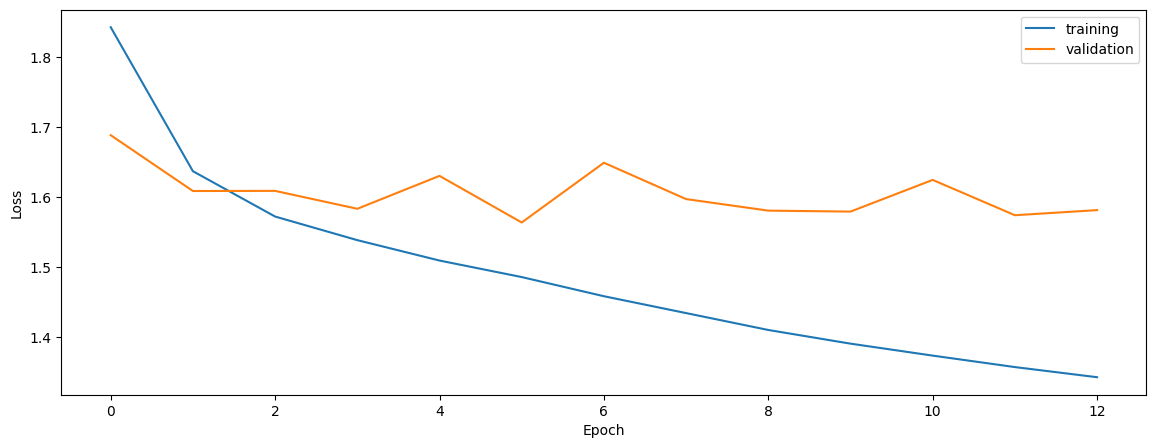

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.43221129592025576
0.40137699636476404
0.41948609999652064


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.45821279184728875
0.4459579388984509
0.4438288032808342


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.4581147773959329
0.43921223456925956
0.4537616069736593


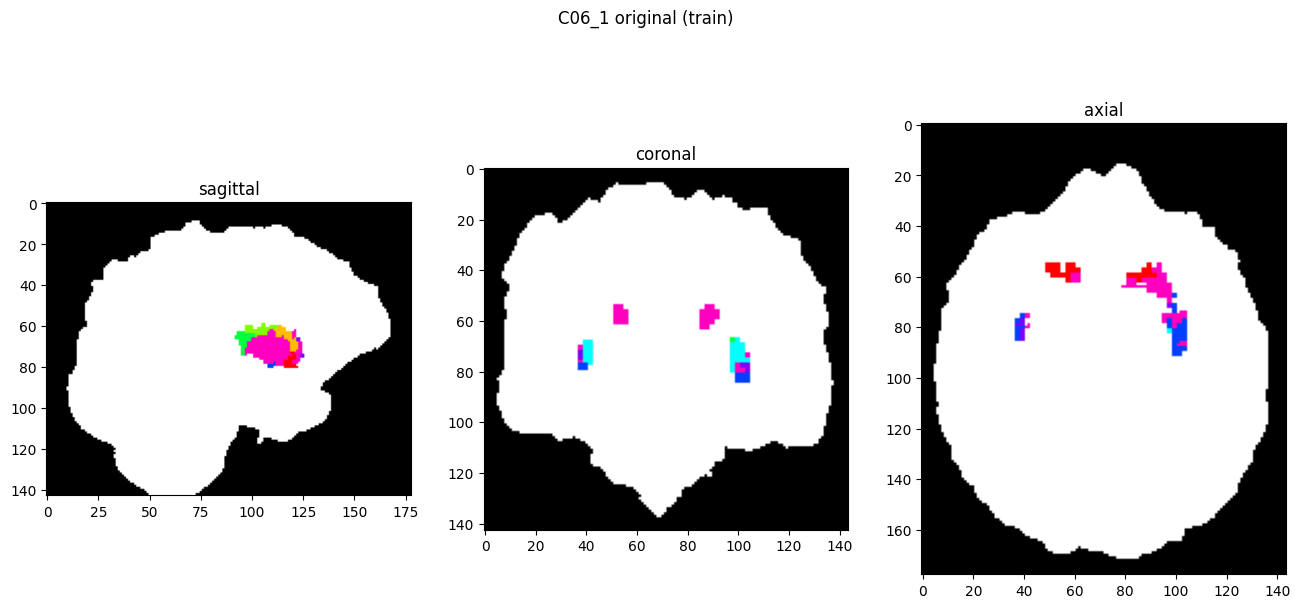

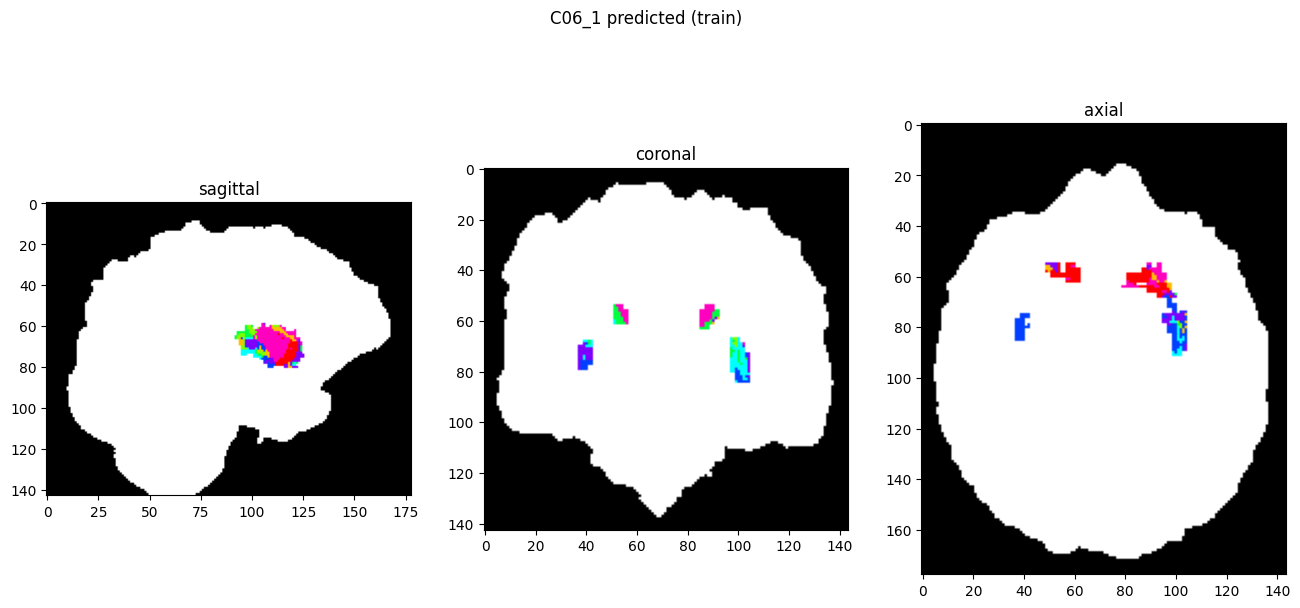

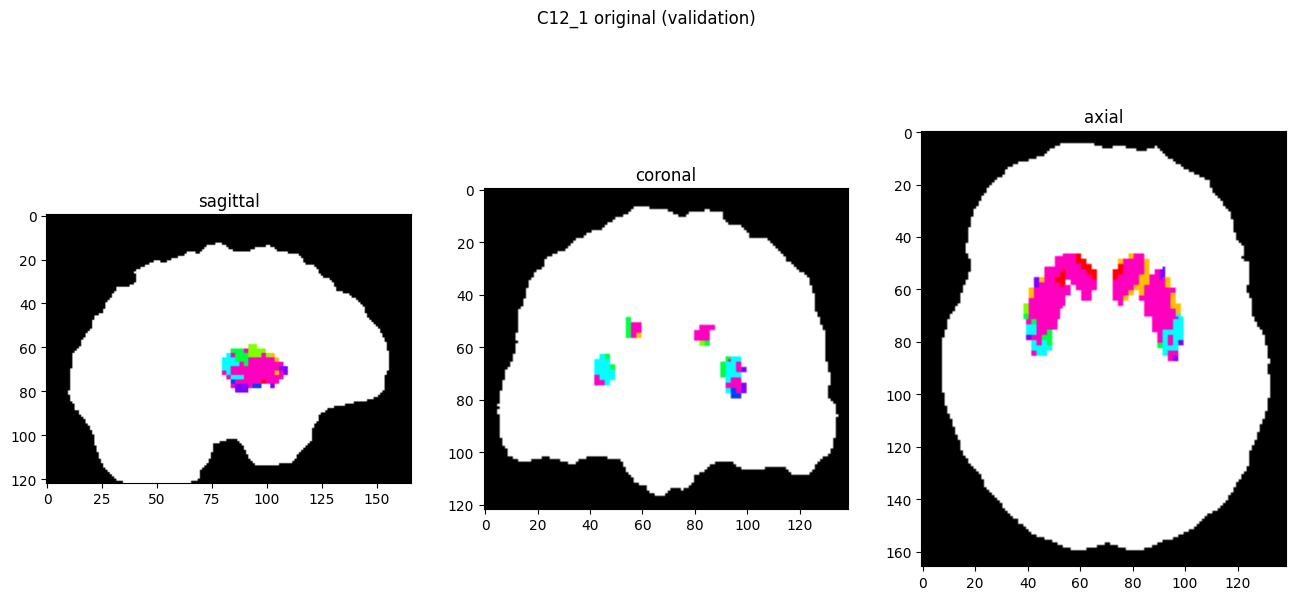

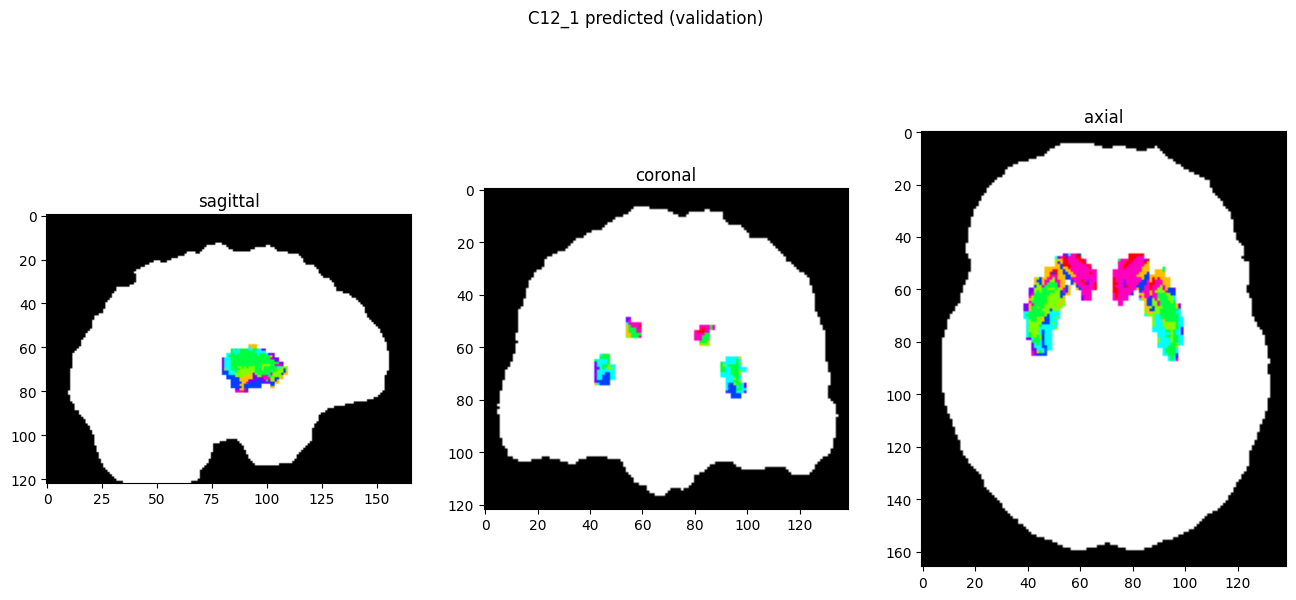

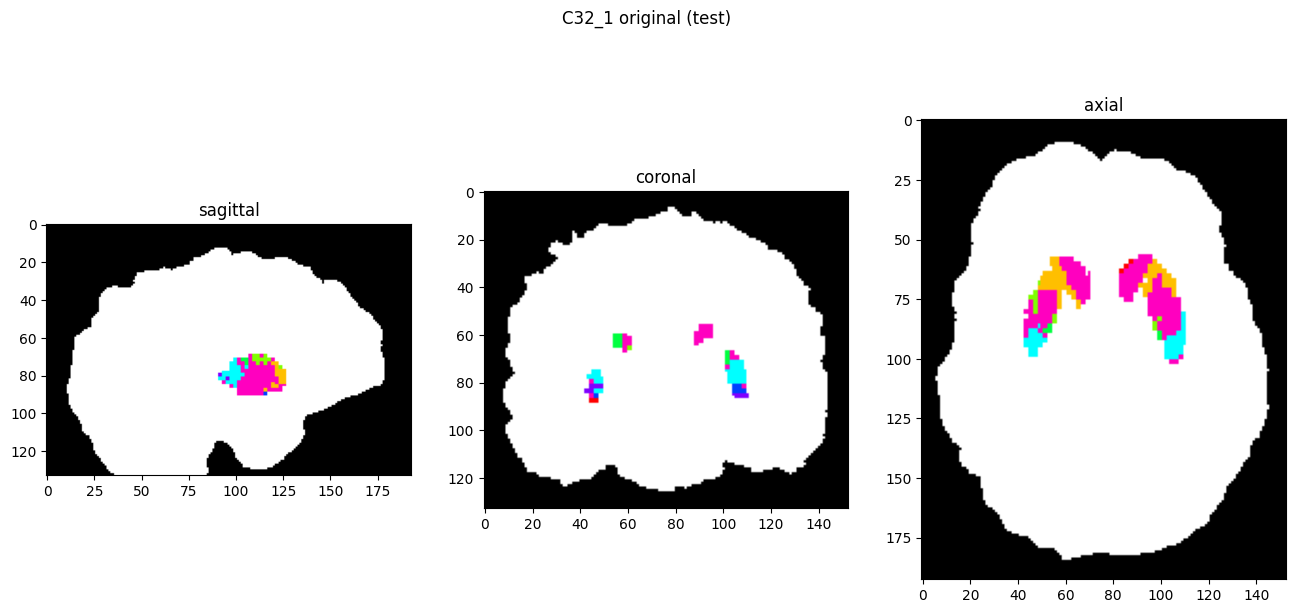

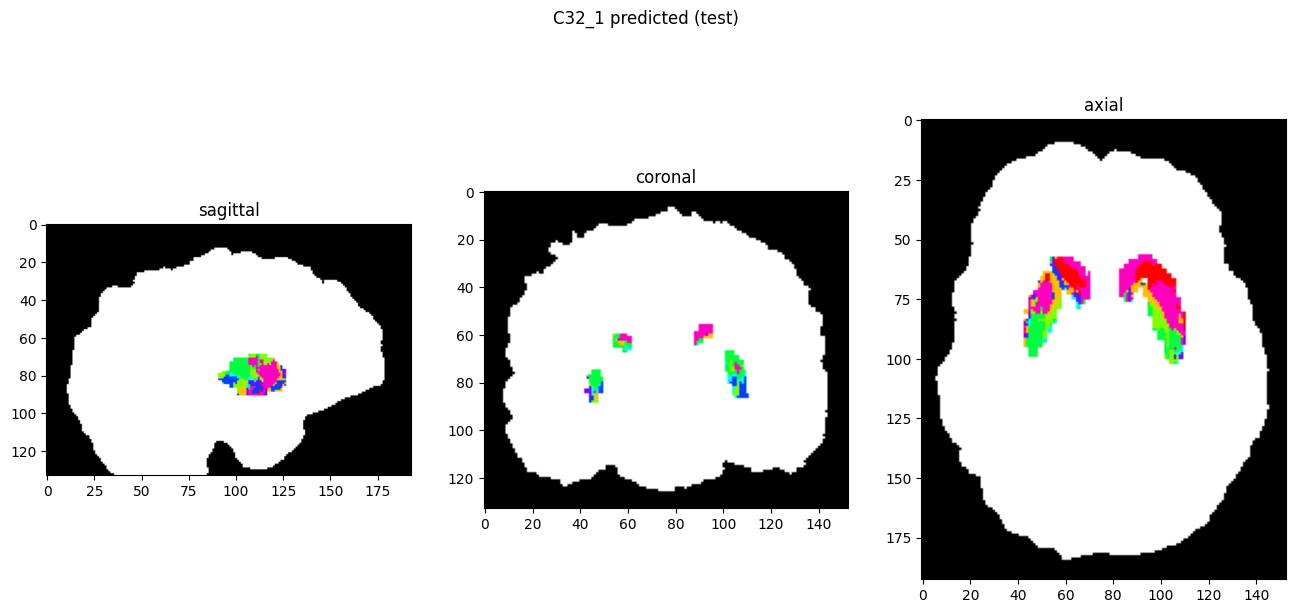

In [10]:
showResults(model, gen, threshold=0)